In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import pickle as pkl
import seaborn as sns

from scipy import stats
#from scipy.stats import cumfreq
import statsmodels.api as sm

from tabulate import tabulate
from scipy.stats import f

import os

In [45]:
os.chdir("/Users/avascharfstein/Desktop/Dartmouth/mds-final")

In [46]:
df = pd.read_csv('data/df_relabeled.csv')
with open('data/specific_stats.pkl', 'rb') as f:
    specific_stats = pkl.load(f)
with open('data/overall_stats.pkl', 'rb') as f:
    overall_stats = pkl.load(f)
with open('data/context_vars.pkl', 'rb') as f:
    context_vars = pkl.load(f)

stats_df = df.drop(columns = context_vars)

In [47]:
def dist_measures(dist):
    mean = np.mean(dist)
    median = np.median(dist)
    std = np.std(dist)
    if std==0:
        skew = 0
    else:
        skew = 3*(mean-median)/std
    return [mean, median, skew, std]

def plt_dist(df, var, xlabel= None):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]
    [m_mean, m_median, m_skew, m_std] = dist_measures(m_dist)
    [w_mean, w_median, w_skew, w_std] = dist_measures(w_dist)
    metric = "Mean" # default metric is mean
    m_metric = m_mean
    w_metric = w_mean
    #Assume skewness is >0 since there will be no negative values (FOR NOW)
    if m_skew > .5 or w_skew >.5: # if one of the distributions is skewed heavily..
        metric = "Median"
        m_metric = m_median
        w_metric = w_median

    if xlabel is None:
        xlabel = var.replace("_"," ").title()

    sns.histplot(m_dist, alpha=0.6, label='Mens', color='skyblue',edgecolor='white')
    sns.histplot(w_dist, alpha=0.4, label='Womens', color='orange',edgecolor='white') 

    plt.axvline(m_metric, color='skyblue', linestyle='dashed', linewidth=3)
    plt.axvline(w_metric, color='orange', linestyle='dashed', linewidth=3)
    #plt.title("Dashed Line represents " + metric, fontsize=7)
    plt.suptitle("Histogram of " + var.replace("_", " ").title())
    plt.text(0.5, -0.15, f"Dashed Line represents {metric}", horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontdict={'fontsize': 8, 'fontstyle': 'italic'})
    plt.xlabel(xlabel)
    plt.ylabel("Matches")
    plt.legend(loc='upper right')
    plt.show()

In [48]:
h = "_home"
a = "_away"

In [49]:
specific_stats.remove('rs')
specific_stats.remove('seed')
specific_stats.remove('win')

In [50]:
features_sum = []
for stat in specific_stats:
    stats_df[stat+"_sum"] = stats_df[stat+h]+ stats_df[stat+a]
    features_sum.append(stat+"_sum")

#features_diff.append("avg_set_diff")

for x in [x for x in overall_stats if x not in ['match_length','sets','men']]:
    features_sum.append(x)


In [51]:
# Remove features whose mean and variance < 1
to_remove = []
for feature in specific_stats:
    ms = dist_measures(stats_df[feature+"_sum"])
    ms_h = dist_measures(stats_df[feature+h])
    ms_a = dist_measures(stats_df[feature+a])
    if ms_h[0] < 1 and ms_h[0] < 1 and ms_h[3] < 1 and ms_a[3] <1:
        to_remove.append(feature+"_sum")
        print("Removed "+feature+"_sum")

features_sum = list(set(features_sum) - set(to_remove))

Removed tiebreaks_won_sum


In [52]:
features_sum_df = stats_df[features_sum]

In [53]:
def plt_ecdf(df, var, xlabel=None):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]

    ks = stats.kstest(m_dist, w_dist)

    m_x, m_cf = np.sort(m_dist), np.arange(1, len(m_dist) + 1) / len(m_dist)
    w_x, w_cf = np.sort(w_dist), np.arange(1, len(w_dist) + 1) / len(w_dist)

    if xlabel is None:
        xlabel = var.replace("_", " ").title()

    plt.step(x=m_x, y=m_cf, label='Mens', color='skyblue')
    plt.step(x=w_x, y=w_cf, label='Womens', color='orange')

    plt.title("Empirical CDF of " + var.replace("_", " ").title())
    plt.xlabel(xlabel)
    plt.ylabel("Cumulative Probability")
    plt.legend(loc='lower right')
    # Display KS test statistic and p-value
    plt.text(0.5, -0.15, f"KS Statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}", horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontdict={'fontsize': 8, 'fontstyle': 'italic'})
    
    plt.show()


In [65]:
def summarize(df, var):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]
    m_results = stats.describe(m_dist)
    w_results = stats.describe(w_dist)
    
    summary_data = [
        ["Mean", m_results.mean, w_results.mean],
        ["Median", np.median(m_dist), np.median(w_dist)],
        ["Variance", m_results.variance, w_results.variance],
        ["Skewness", m_results.skewness, w_results.skewness],
        ["Kurtosis", m_results.kurtosis, w_results.kurtosis],
    ]

    significant = []

    # KS-Test for distributions
    ks_stat, ks_p_value = stats.kstest(m_dist, w_dist)
    if ks_p_value <.05:
        significant.append("KS-Test")

    # T-test for means
    t_stat, t_p_value = stats.ttest_ind(m_dist, w_dist)
    if t_p_value < .05:
        significant.append("T-test")

    # Mann-Whitney U test (non-parametric test for comparing distributions)
    u_stat, mw_p_value = stats.mannwhitneyu(m_dist, w_dist)
    if mw_p_value < .05:
        significant.append("Mann-Whitney U")

    # F-test for variances
    f_stat, f_p_value = stats.levene(m_dist, w_dist)
    if f_p_value < .05:
        significant.append("Levene")

    
    if m_results.skewness >= .5 or m_results.skewness <= -.5:
        significant.append("M-Skew")
    if w_results.skewness >= .5 or w_results.skewness <= -.5:
        significant.append("W-Skew")

    # Results table
    results_table = [
        ["KS-test (Distribution)", ks_stat, ks_p_value],
        ["T-test (Means)", t_stat, t_p_value],
        ["Mann-Whitney U", u_stat, mw_p_value],
        ["Levene-test (Variances)", f_stat, f_p_value],
    ]
    
    var_format = var.replace("_"," ")
    # Print the tables
    print(f"Summary Statistics for {var_format.title()}:")
    print(tabulate(summary_data, headers=["Statistic", "Men", "Women"], tablefmt="grid"))
    print(tabulate(results_table, headers=["Test", "Statistic", "P-value"], tablefmt="grid"))
    print("Tests that are statistically significant:"+str(significant))
    print('\n\n')

def plt_qq(df, var, name):
    m_dist = df[df['men']][var]
    w_dist = df[~df['men']][var]


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    stats.probplot(m_dist, plot=axes[0])
    axes[0].set_title('Mens')
    axes[0].get_lines()[0].set_markeredgecolor('none')
    axes[0].get_lines()[0].set_markerfacecolor('skyblue')  # Set color for Men's QQ plot
    axes[0].get_lines()[1].set_color('black')  # Set color for the line


    stats.probplot(w_dist, plot=axes[1])
    axes[1].set_title('Womens')
    axes[1].get_lines()[0].set_markeredgecolor('none')
    axes[1].get_lines()[0].set_markerfacecolor('orange')  # Set color for Women's QQ plot
    axes[1].get_lines()[1].set_color('black')


    fig.suptitle(name)
    plt.show();

Summary Statistics for Aces Sum:
+-------------+----------+----------+
| Statistic   |      Men |    Women |
+=============+==========+==========+
| Mean        | 4.70041  | 2.20887  |
+-------------+----------+----------+
| Median      | 4.33333  | 2        |
+-------------+----------+----------+
| Variance    | 5.67599  | 2.44561  |
+-------------+----------+----------+
| Skewness    | 0.891259 | 0.859272 |
+-------------+----------+----------+
| Kurtosis    | 0.900642 | 0.533792 |
+-------------+----------+----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.488519 | 1.13372e-51 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     18.9158   | 6.67186e-68 |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 182819        | 8.35152e-65 |
+--------

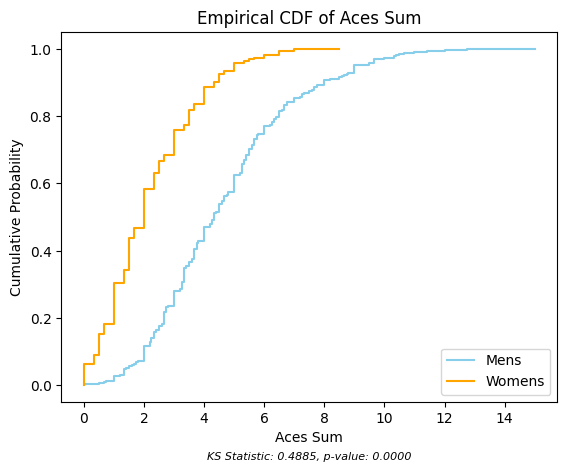

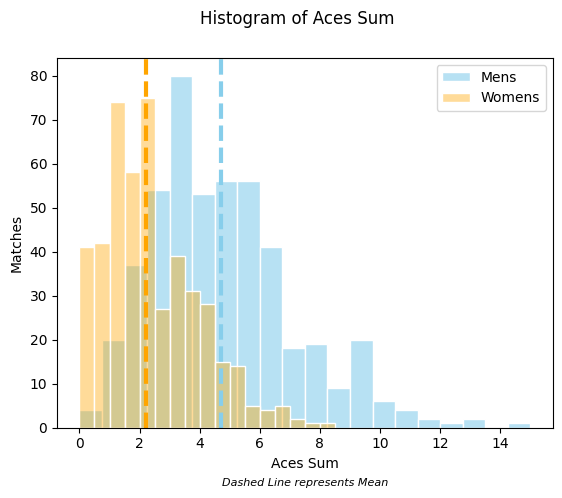

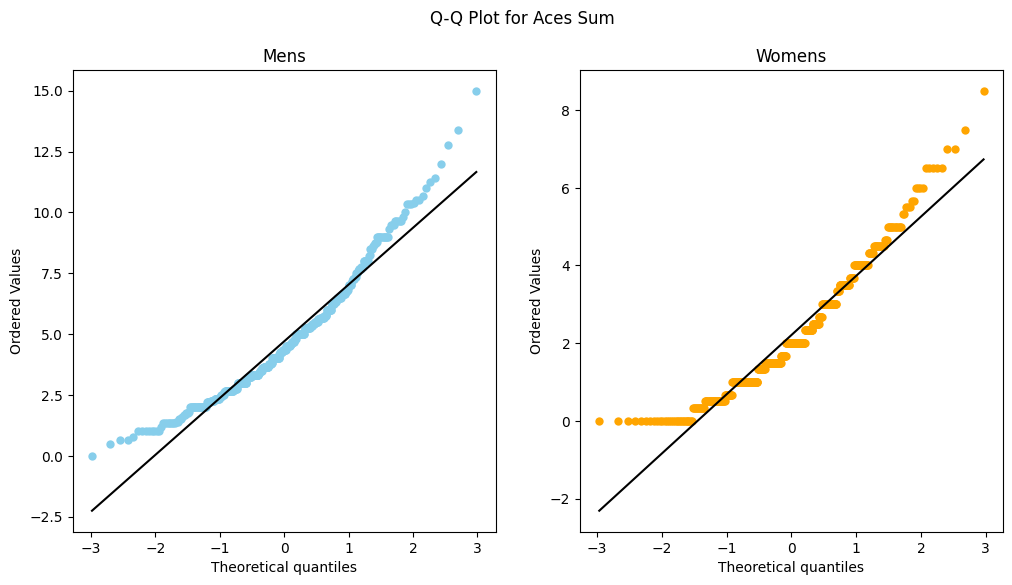

Summary Statistics for Avg Game Length:
+-------------+------------+----------+
| Statistic   |        Men |    Women |
+=============+============+==========+
| Mean        |  4.6178    | 4.74881  |
+-------------+------------+----------+
| Median      |  4.59808   | 4.7244   |
+-------------+------------+----------+
| Variance    |  0.328538  | 0.414392 |
+-------------+------------+----------+
| Skewness    |  0.257596  | 0.42051  |
+-------------+------------+----------+
| Kurtosis    | -0.0342572 | 0.383443 |
+-------------+------------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.105778 | 0.00919852  |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -3.30729  | 0.000977622 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 98829        

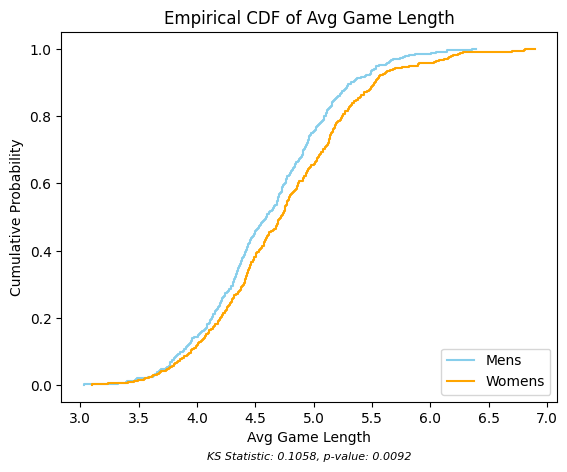

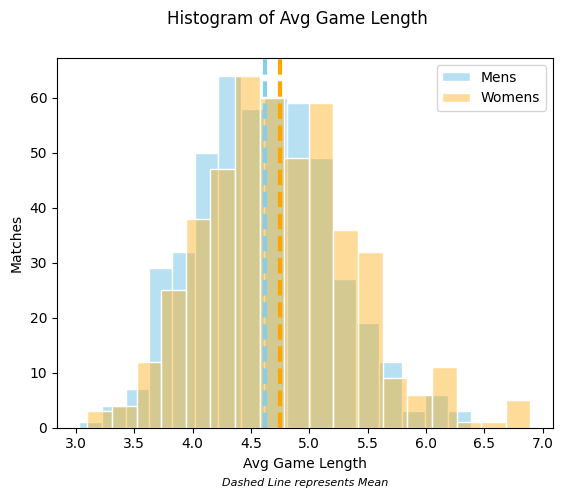

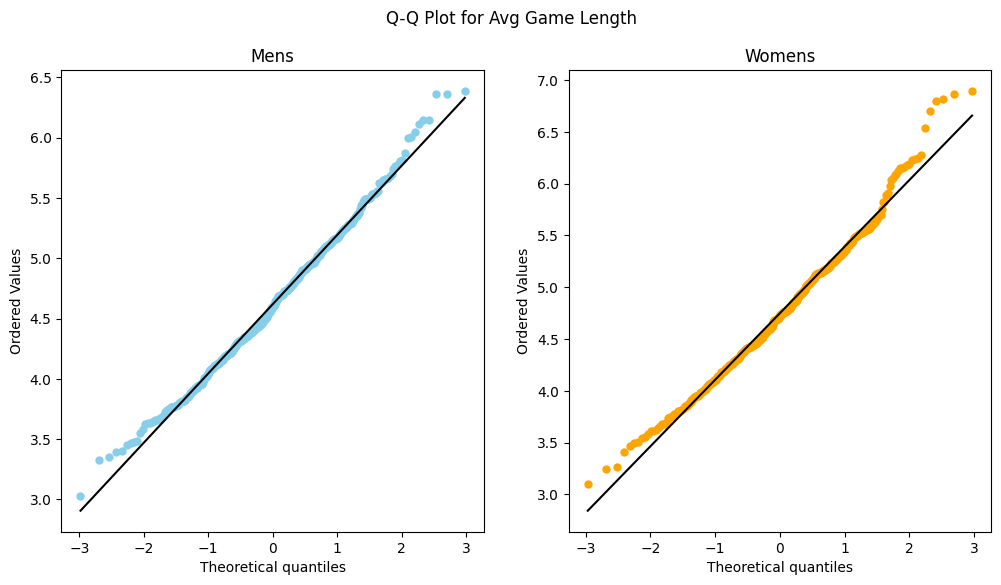

Summary Statistics for Avg Points Per Game:
+-------------+----------+----------+
| Statistic   |      Men |    Women |
+=============+==========+==========+
| Mean        | 6.31197  | 6.55563  |
+-------------+----------+----------+
| Median      | 6.2619   | 6.52661  |
+-------------+----------+----------+
| Variance    | 0.222113 | 0.367988 |
+-------------+----------+----------+
| Skewness    | 0.70404  | 0.333225 |
+-------------+----------+----------+
| Kurtosis    | 1.17176  | 0.387261 |
+-------------+----------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.230284 | 1.77399e-11 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -6.91228  | 8.77739e-12 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 82233.5      | 2.64842e-12 |
+-----

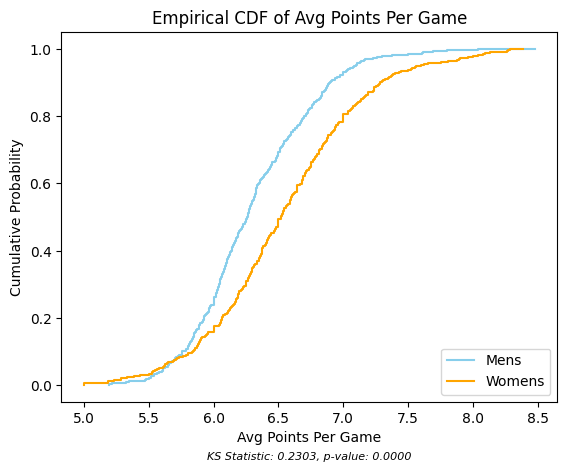

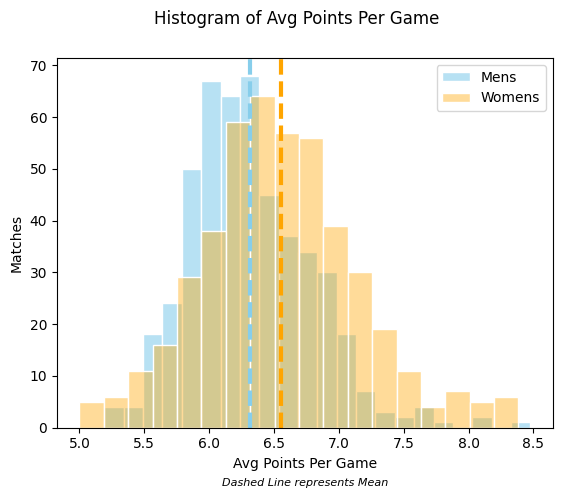

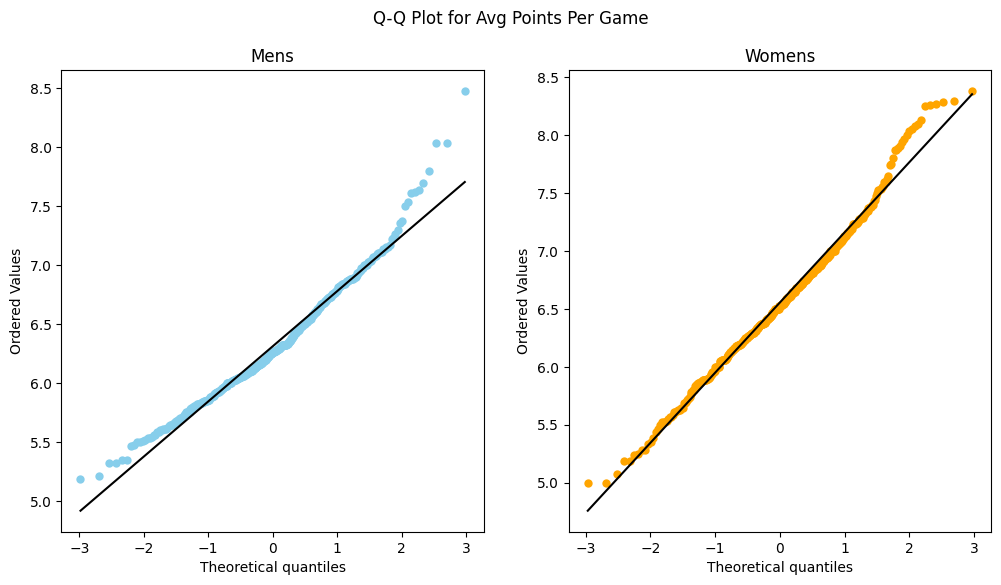

Summary Statistics for Avg Set Diff:
+-------------+------------+------------+
| Statistic   |        Men |      Women |
+=============+============+============+
| Mean        |  0.0198413 | -0.0753968 |
+-------------+------------+------------+
| Median      |  0         |  0         |
+-------------+------------+------------+
| Variance    |  5.00272   |  8.3524    |
+-------------+------------+------------+
| Skewness    | -0.023032  |  0.0779285 |
+-------------+------------+------------+
| Kurtosis    | -0.935462  | -1.13928   |
+-------------+------------+------------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.14728  | 6.08217e-05 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      0.567933 | 0.570216    |
+-------------------------+---------------+-------------+
| Mann-Whit

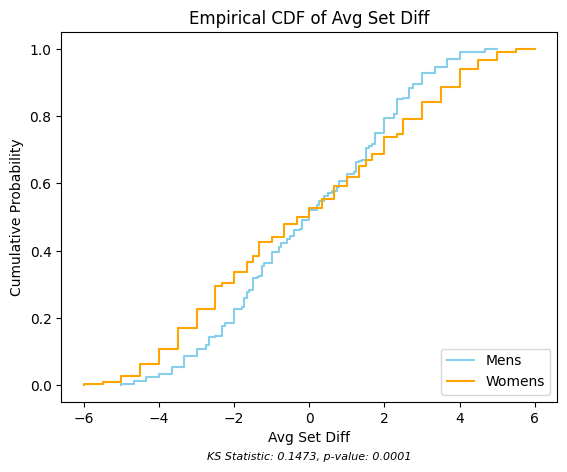

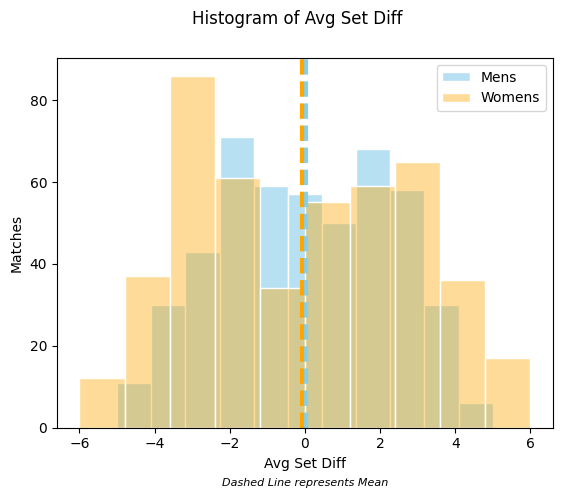

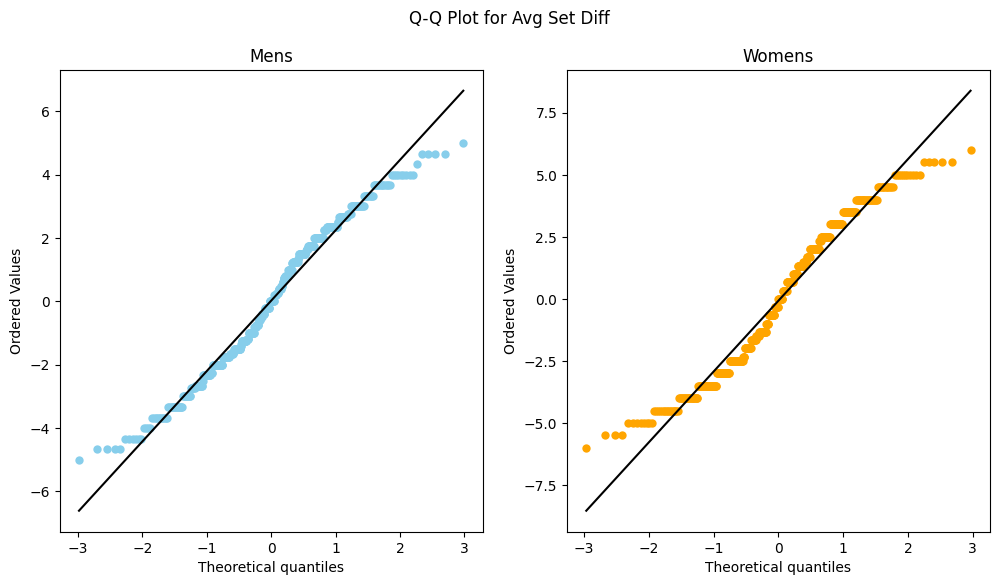

Summary Statistics for Avg Set Games:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        |  9.70914   |  9.15476  |
+-------------+------------+-----------+
| Median      |  9.75      |  9        |
+-------------+------------+-----------+
| Variance    |  1.17076   |  1.76263  |
+-------------+------------+-----------+
| Skewness    |  0.0133711 |  0.31314  |
+-------------+------------+-----------+
| Kurtosis    | -0.215308  | -0.128478 |
+-------------+------------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.248635 | 2.54311e-13 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      7.05011  | 3.45299e-12 |
+-------------------------+---------------+-------------+
| Mann-Whitney U       

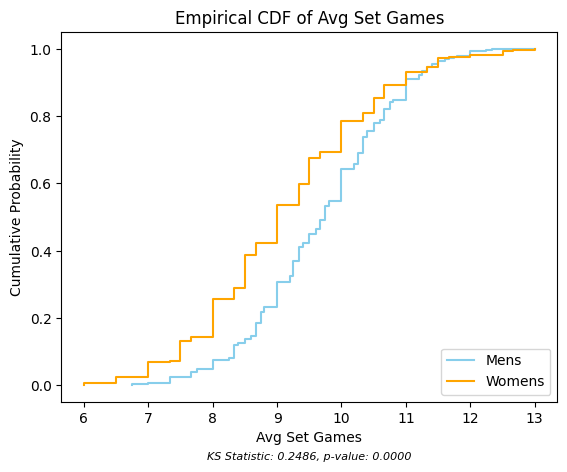

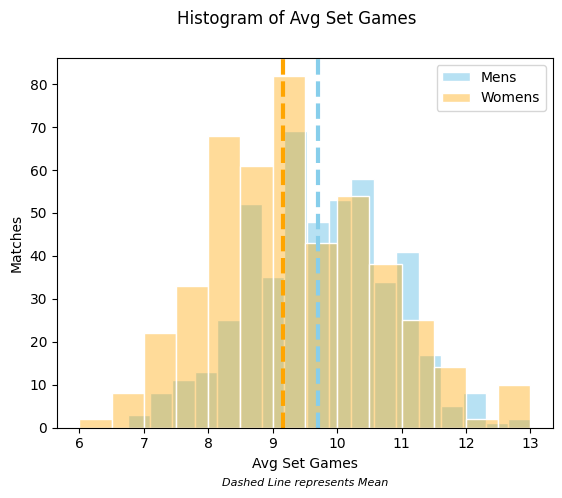

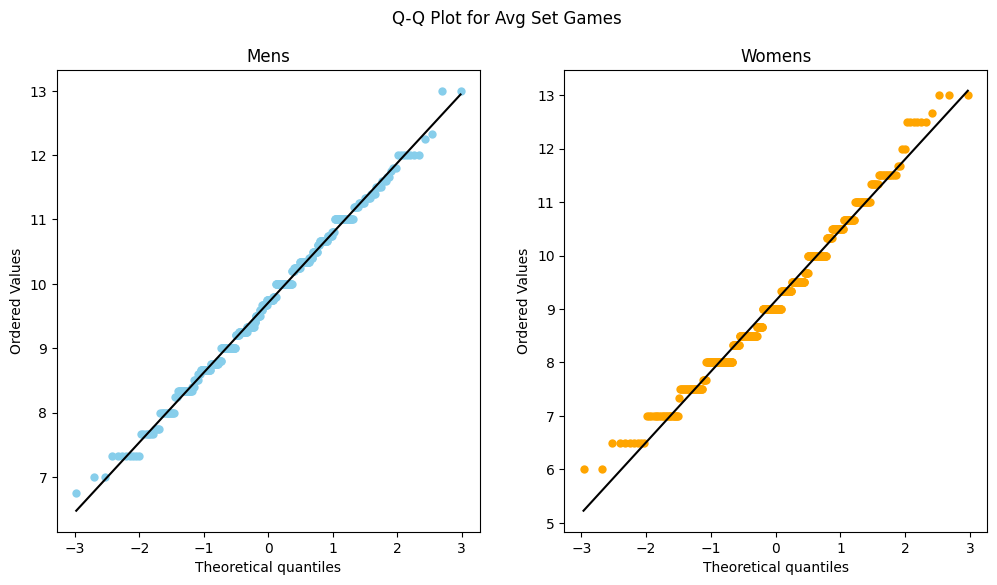

Summary Statistics for Avg Set Length:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 44.8134   | 43.6735   |
+-------------+-----------+-----------+
| Median      | 44.3      | 42.9292   |
+-------------+-----------+-----------+
| Variance    | 55.7151   | 97.3383   |
+-------------+-----------+-----------+
| Skewness    |  0.258821 |  0.620146 |
+-------------+-----------+-----------+
| Kurtosis    |  0.110722 |  0.440302 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.159797 | 9.67076e-06 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      2.00843  | 0.044882    |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 123925 

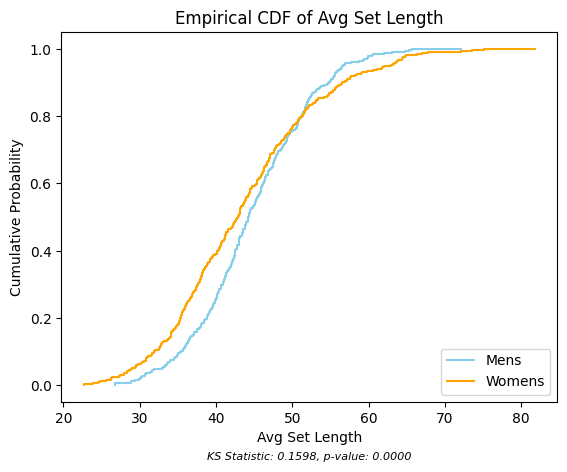

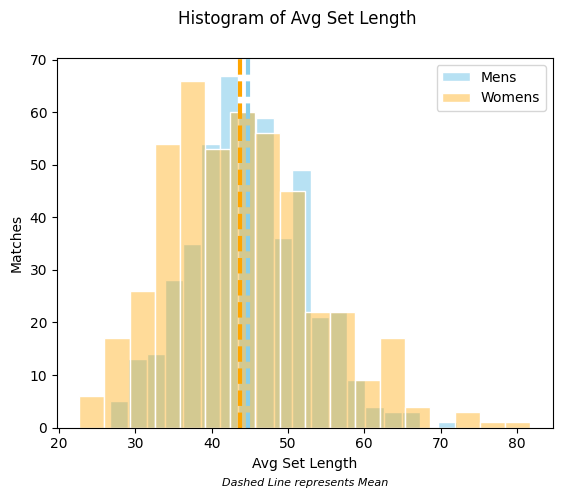

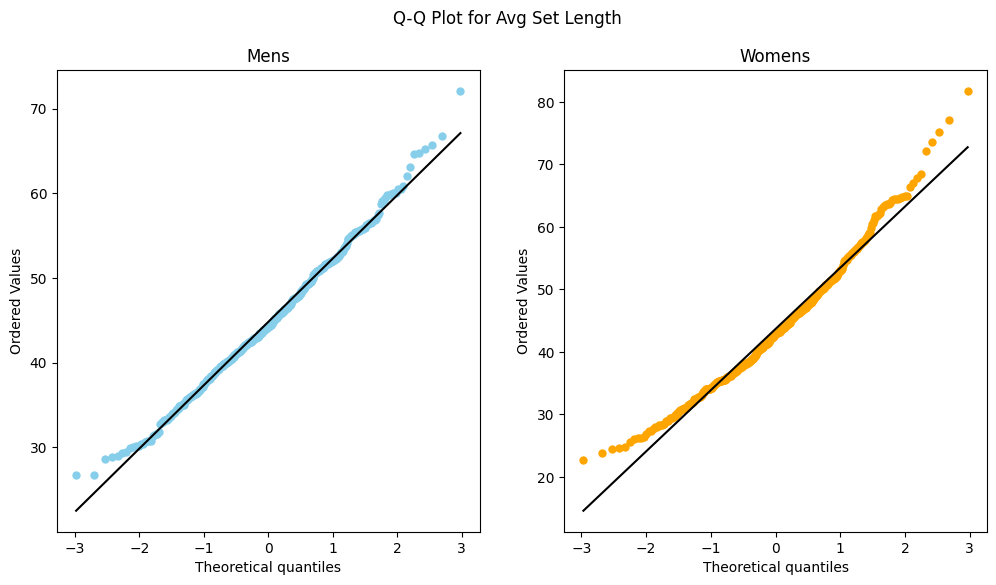

Summary Statistics for Breakpoints Won Sum:
+-------------+----------+----------+
| Statistic   |      Men |    Women |
+=============+==========+==========+
| Mean        | 1.99731  | 3.20491  |
+-------------+----------+----------+
| Median      | 2        | 3        |
+-------------+----------+----------+
| Variance    | 0.555266 | 1.39309  |
+-------------+----------+----------+
| Skewness    | 0.624009 | 0.633877 |
+-------------+----------+----------+
| Kurtosis    | 1.55458  | 0.558022 |
+-------------+----------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.532091 | 9.54476e-62 |
+-------------------------+--------------+-------------+
| T-test (Means)          |   -18.8917   | 9.29446e-68 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 41624        | 1.13277e-62 |
+-----

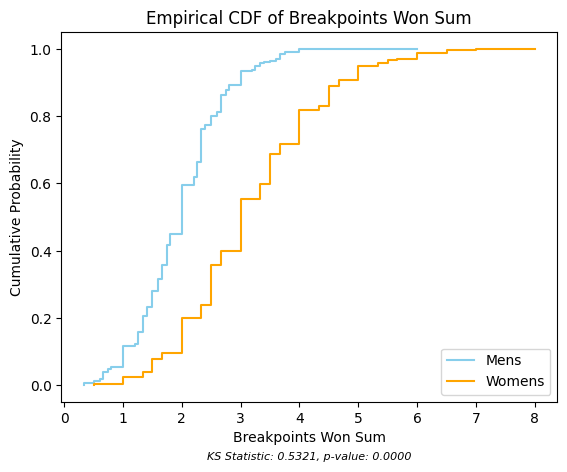

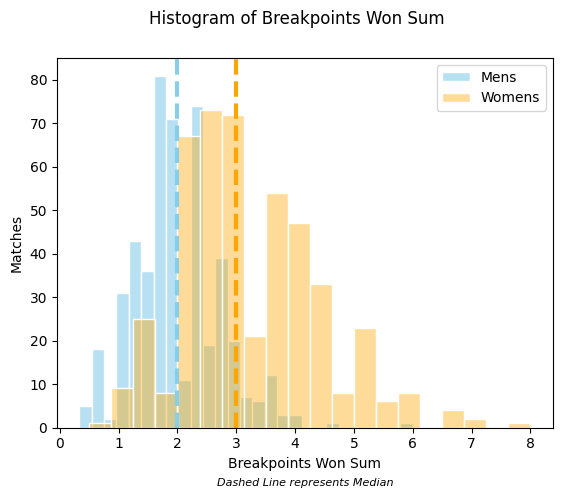

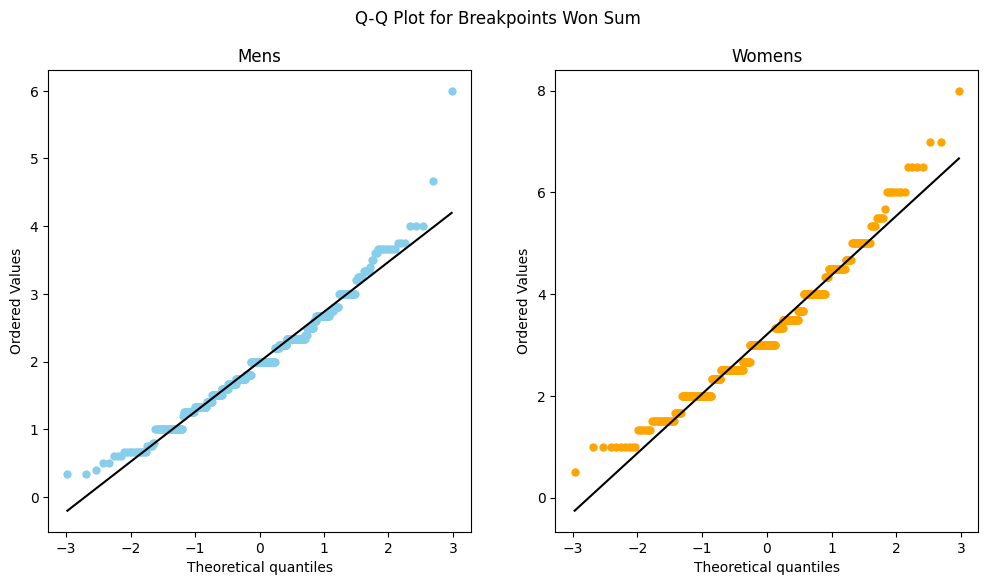

Summary Statistics for Double Faults Sum:
+-------------+---------+----------+
| Statistic   |     Men |    Women |
+=============+=========+==========+
| Mean        | 2.20297 | 3.1075   |
+-------------+---------+----------+
| Median      | 2       | 3        |
+-------------+---------+----------+
| Variance    | 1.16729 | 2.54024  |
+-------------+---------+----------+
| Skewness    | 1.1022  | 0.730833 |
+-------------+---------+----------+
| Kurtosis    | 2.96509 | 0.379053 |
+-------------+---------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.281856 | 4.92883e-17 |
+-------------------------+--------------+-------------+
| T-test (Means)          |   -10.2512   | 1.88263e-23 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 72997        | 3.22723e-20 |
+--------------------

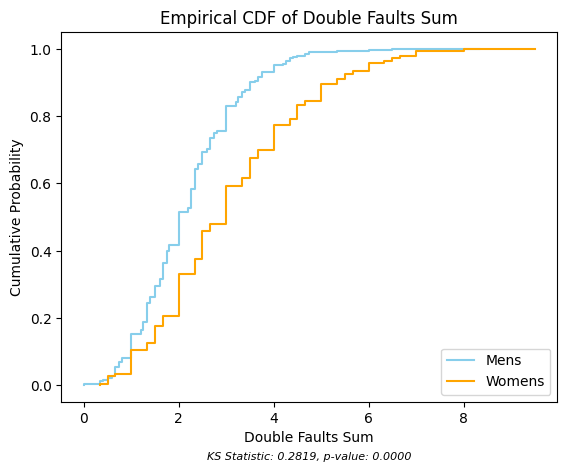

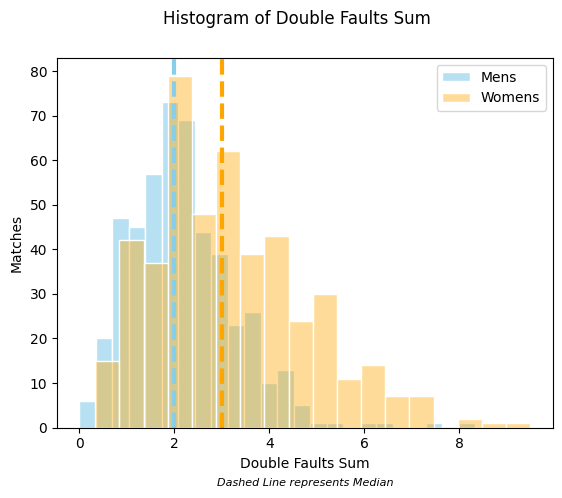

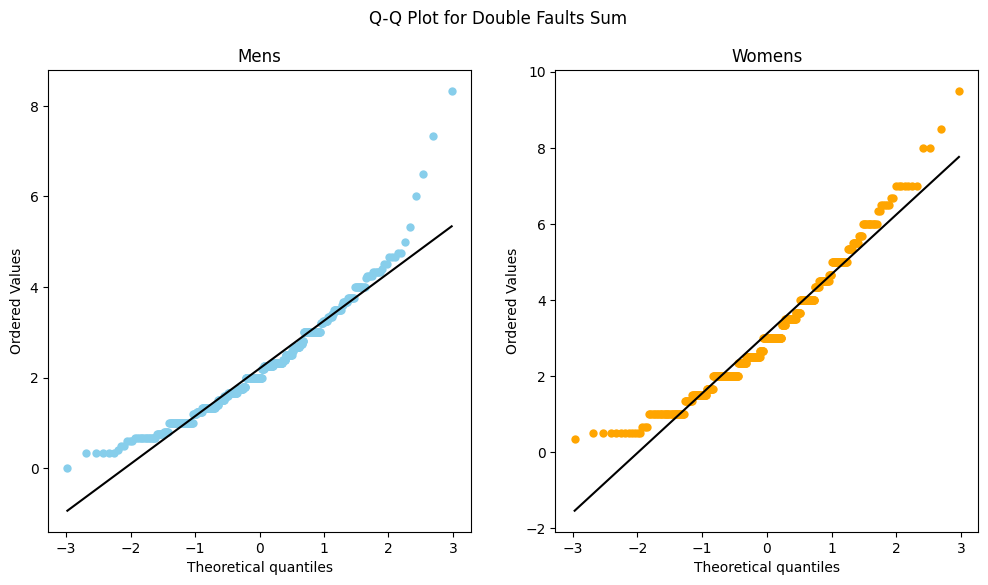

Summary Statistics for Errors Sum:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        | 41.8841   |  36.1714   |
+-------------+-----------+------------+
| Median      | 41.3333   |  35        |
+-------------+-----------+------------+
| Variance    | 91.756    | 120.678    |
+-------------+-----------+------------+
| Skewness    |  0.154906 |   0.380361 |
+-------------+-----------+------------+
| Kurtosis    |  0.518572 |  -0.239272 |
+-------------+-----------+------------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.269622 | 1.30811e-15 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      8.53066  | 5.74156e-17 |
+-------------------------+---------------+-------------+
| Mann-Whitney U          

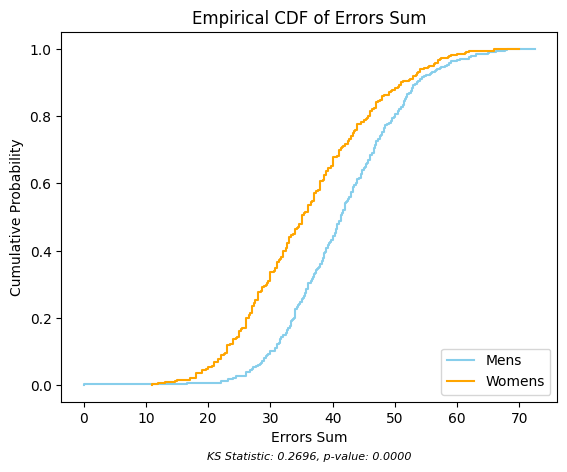

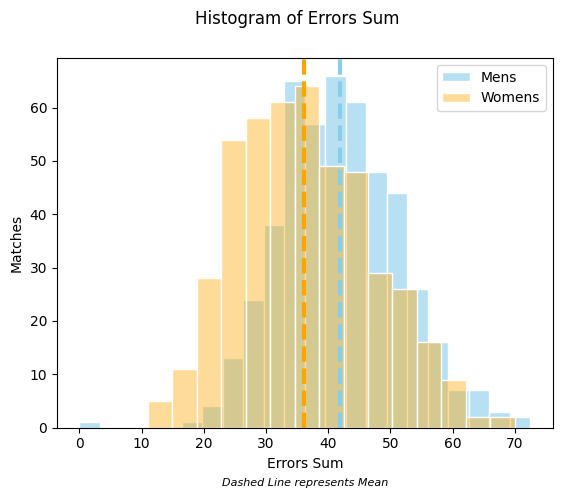

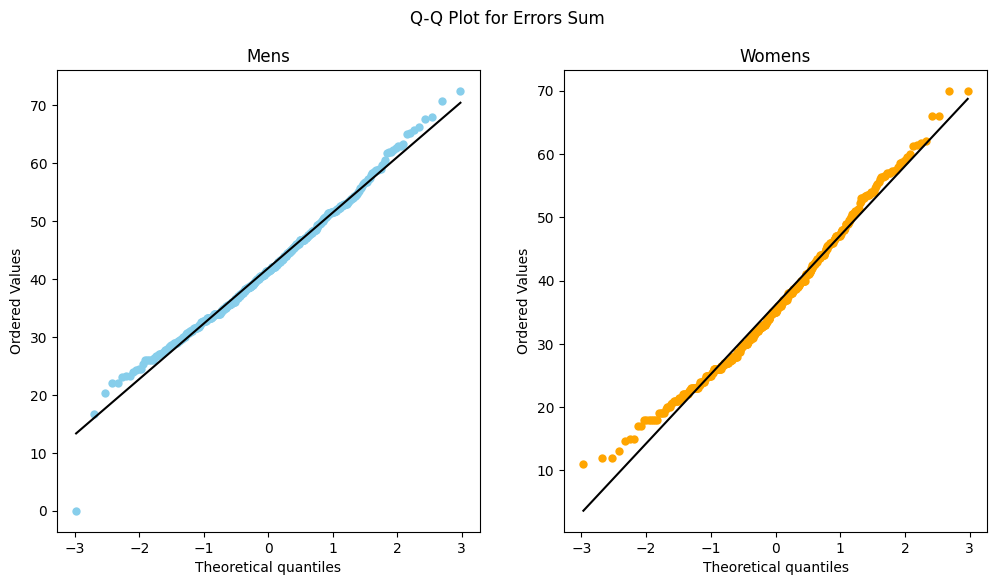

Summary Statistics for First Serve Points Won Sum:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 27.6512   | 23.8849   |
+-------------+-----------+-----------+
| Median      | 27.25     | 23.5      |
+-------------+-----------+-----------+
| Variance    | 29.932    | 33.8872   |
+-------------+-----------+-----------+
| Skewness    |  0.647268 |  0.338262 |
+-------------+-----------+-----------+
| Kurtosis    |  1.51546  | -0.125155 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.280256 | 7.63348e-17 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     10.2524   | 1.86142e-23 |
+-------------------------+---------------+-------------+
| Mann-Whitney U       

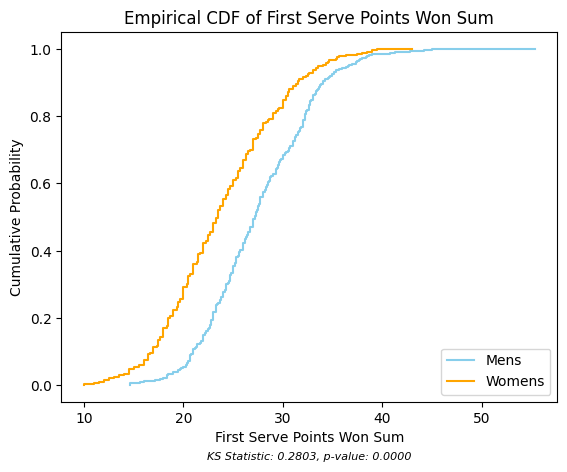

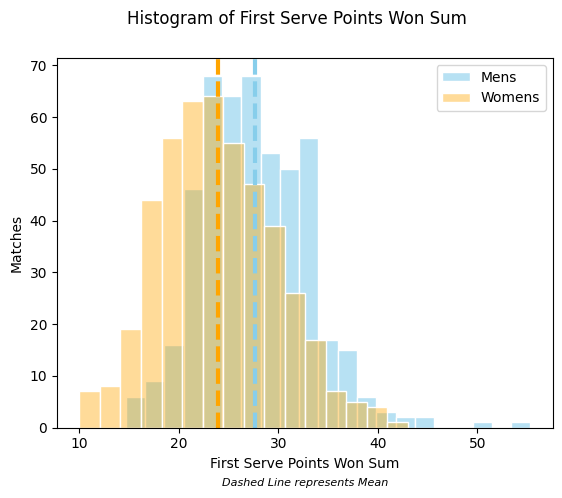

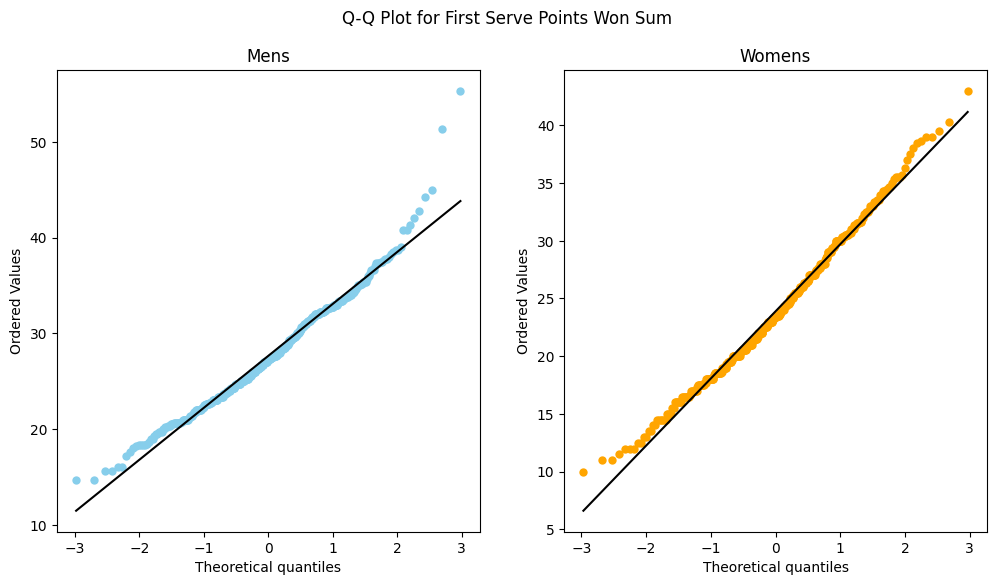

Summary Statistics for First Serve Successful Sum:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 39.2483   | 38.07     |
+-------------+-----------+-----------+
| Median      | 39        | 37.6667   |
+-------------+-----------+-----------+
| Variance    | 51.3037   | 73.6397   |
+-------------+-----------+-----------+
| Skewness    |  0.721349 |  0.316745 |
+-------------+-----------+-----------+
| Kurtosis    |  1.86134  |  0.159802 |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.118107 | 0.00246091  |
+-------------------------+---------------+-------------+
| T-test (Means)          |      2.29552  | 0.0219223   |
+-------------------------+---------------+-------------+
| Mann-Whitney U       

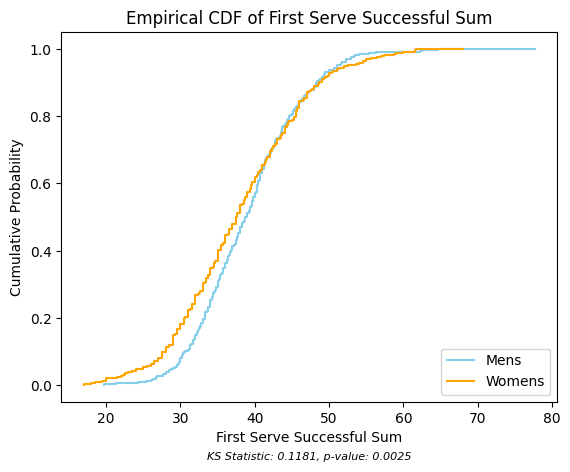

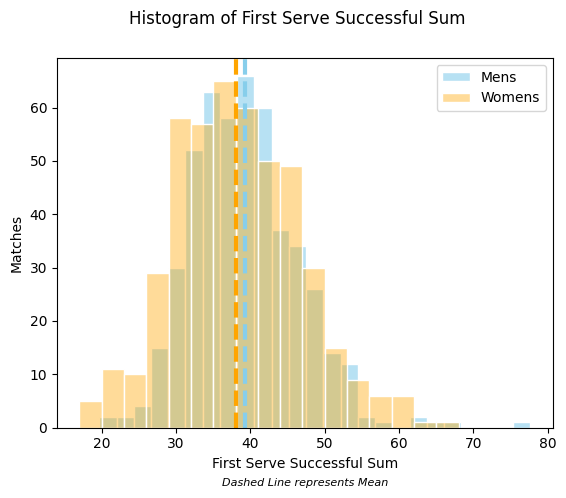

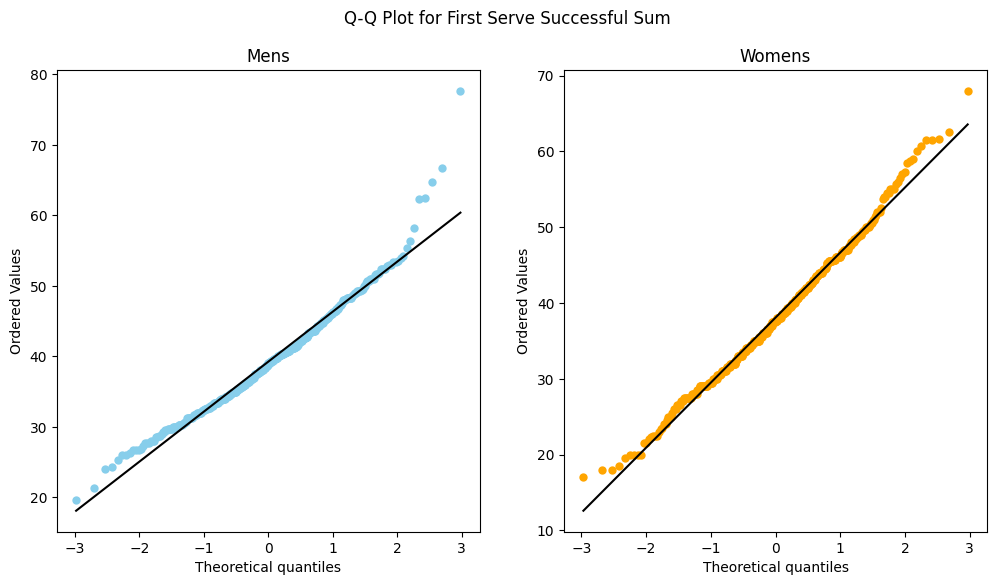

Summary Statistics for Games Won Sum:
+-------------+---------+----------+
| Statistic   |     Men |    Women |
+=============+=========+==========+
| Mean        | 9.74476 | 9.18182  |
+-------------+---------+----------+
| Median      | 9.75    | 9        |
+-------------+---------+----------+
| Variance    | 1.57297 | 1.86588  |
+-------------+---------+----------+
| Skewness    | 1.15567 | 0.493487 |
+-------------+---------+----------+
| Kurtosis    | 6.31488 | 0.599737 |
+-------------+---------+----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.238283 | 2.90626e-12 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      6.60326  | 6.7072e-11  |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 139754        | 1.72517e-11 |
+----------------

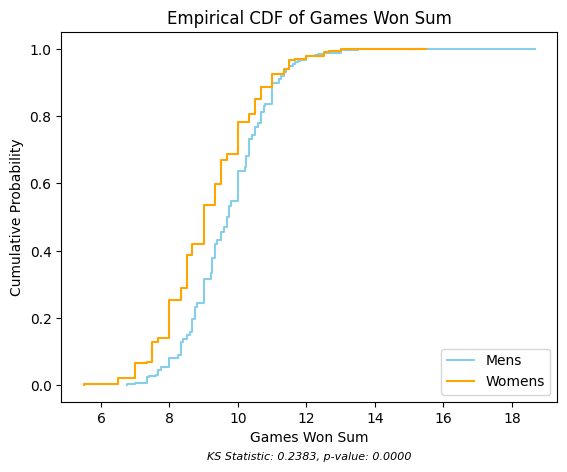

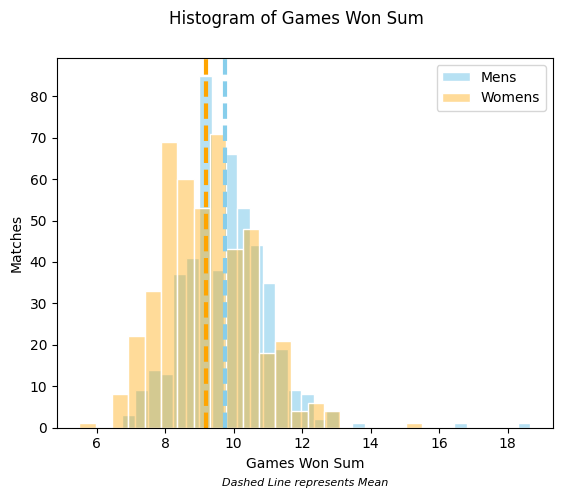

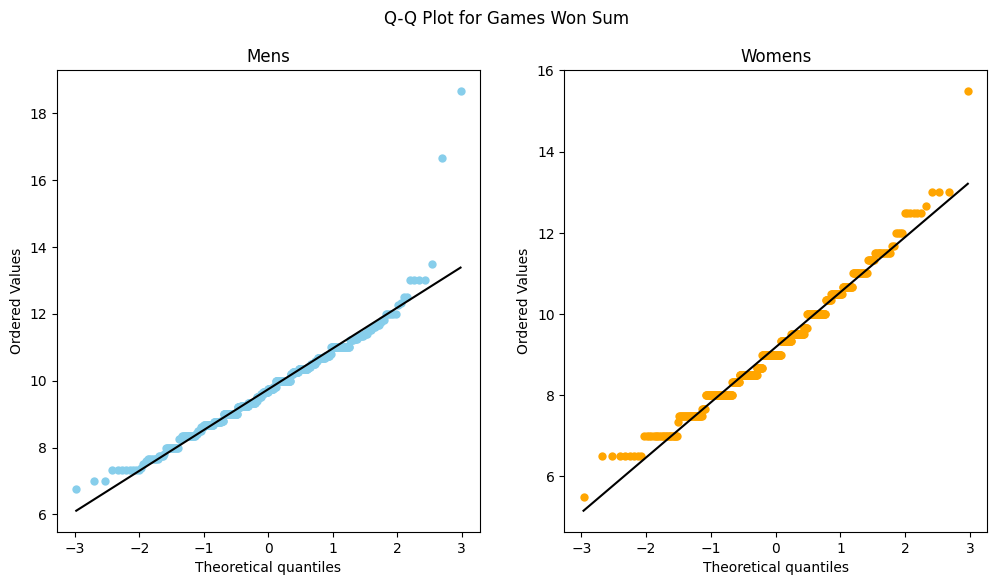

Summary Statistics for Max Games In A Row Sum:
+-------------+----------+----------+
| Statistic   |      Men |    Women |
+=============+==========+==========+
| Mean        | 7.51139  |  7.53463 |
+-------------+----------+----------+
| Median      | 7        |  7       |
+-------------+----------+----------+
| Variance    | 4.70267  |  4.71355 |
+-------------+----------+----------+
| Skewness    | 0.802576 |  2.24025 |
+-------------+----------+----------+
| Kurtosis    | 0.892479 | 13.4757  |
+-------------+----------+----------+
+-------------------------+----------------+-----------+
| Test                    |      Statistic |   P-value |
+=========================+================+===========+
| KS-test (Distribution)  |      0.0566535 |  0.414348 |
+-------------------------+----------------+-----------+
| T-test (Means)          |     -0.164622  |  0.869277 |
+-------------------------+----------------+-----------+
| Mann-Whitney U          | 110018         |  0.706716 |
+--

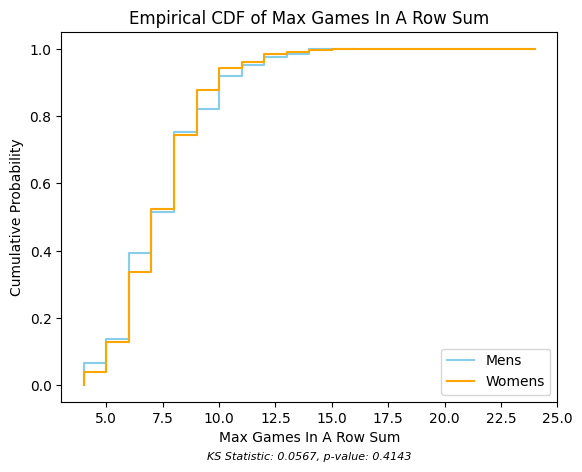

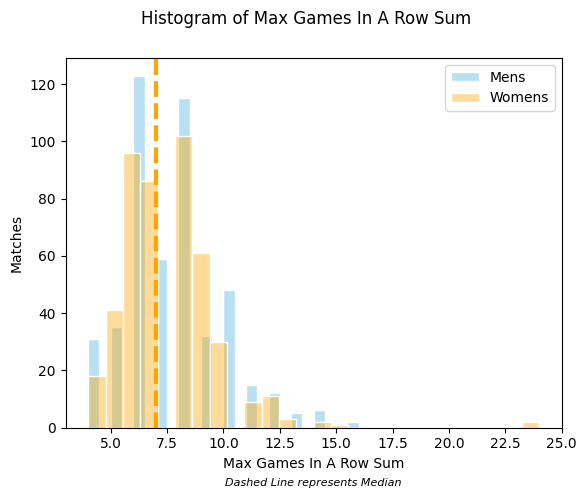

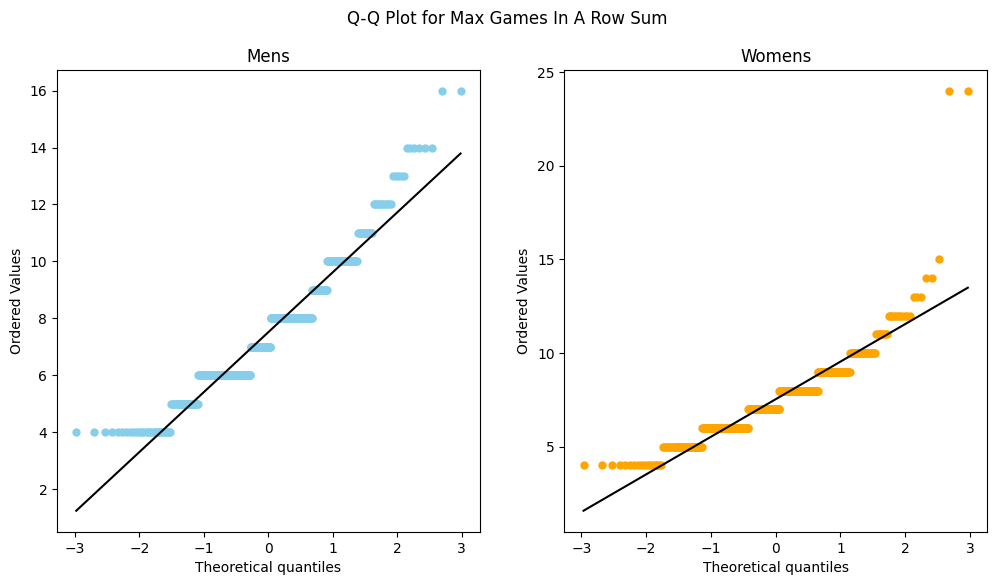

Summary Statistics for Max Points In A Row Sum:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 13.9337   | 13.0736   |
+-------------+-----------+-----------+
| Median      | 14        | 13        |
+-------------+-----------+-----------+
| Variance    |  6.92506  |  6.78416  |
+-------------+-----------+-----------+
| Skewness    |  0.828925 |  0.947173 |
+-------------+-----------+-----------+
| Kurtosis    |  1.10071  |  1.19958  |
+-------------+-----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.155185 | 1.9379e-05  |
+-------------------------+---------------+-------------+
| T-test (Means)          |      5.04794  | 5.3588e-07  |
+-------------------------+---------------+-------------+
| Mann-Whitney U          

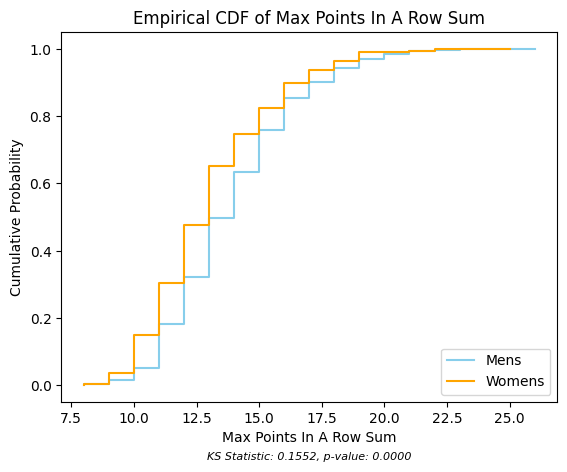

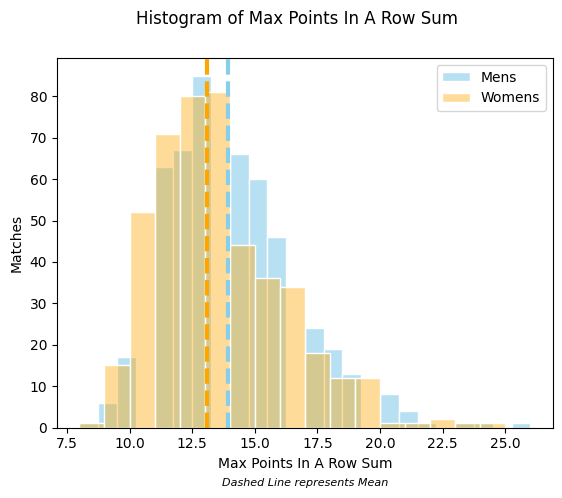

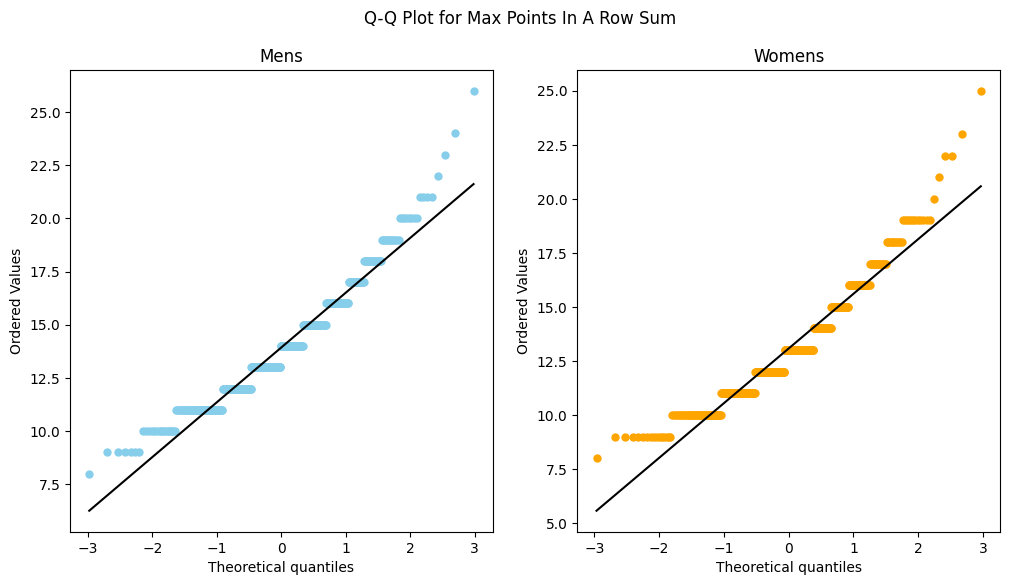

Summary Statistics for Points Won From Last 10 Sum:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        |  2.75542  |  4.40837  |
+-------------+-----------+-----------+
| Median      |  2.5      |  5        |
+-------------+-----------+-----------+
| Variance    |  0.297031 |  0.637404 |
+-------------+-----------+-----------+
| Skewness    | -0.270628 | -0.606143 |
+-------------+-----------+-----------+
| Kurtosis    | -0.683814 | -1.63259  |
+-------------+-----------+-----------+
+-------------------------+--------------+--------------+
| Test                    |    Statistic |      P-value |
+=========================+==============+==============+
| KS-test (Distribution)  |     0.645022 | 3.99564e-93  |
+-------------------------+--------------+--------------+
| T-test (Means)          |   -37.312    | 7.00839e-188 |
+-------------------------+--------------+--------------+
| Mann-Whitney U      

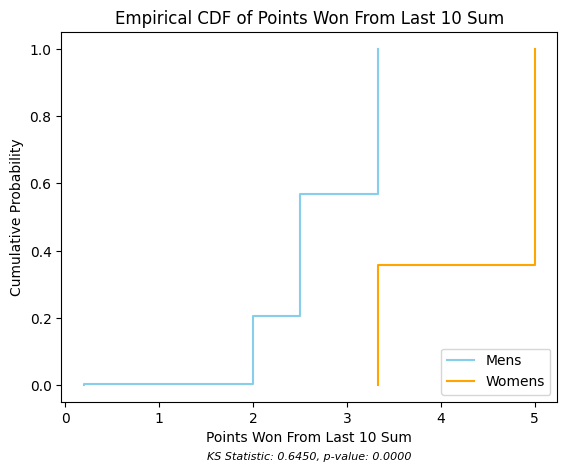

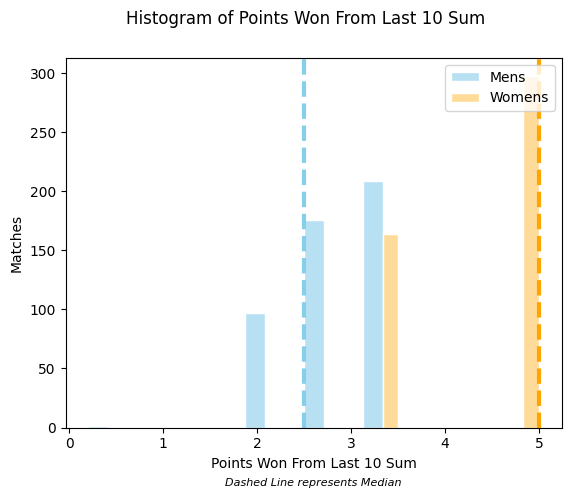

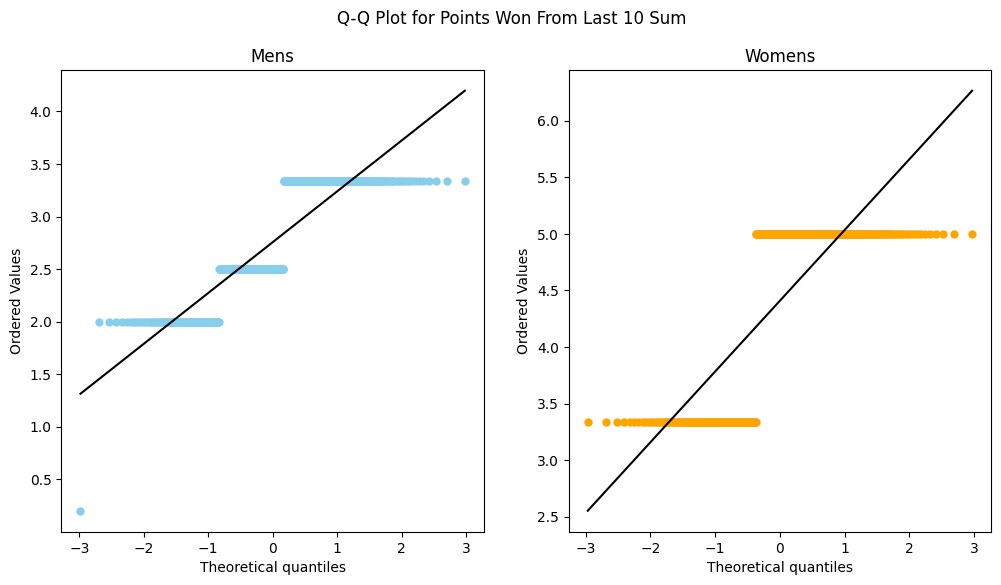

Summary Statistics for Points Won Sum:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        | 61.4591   |  60.1782   |
+-------------+-----------+------------+
| Median      | 61.25     |  59.5833   |
+-------------+-----------+------------+
| Variance    | 79.4415   | 123.322    |
+-------------+-----------+------------+
| Skewness    |  0.728003 |   0.412886 |
+-------------+-----------+------------+
| Kurtosis    |  3.31781  |   0.573466 |
+-------------+-----------+------------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.129305 | 0.000654903 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      1.95952  | 0.0503456   |
+-------------------------+---------------+-------------+
| Mann-Whitney U      

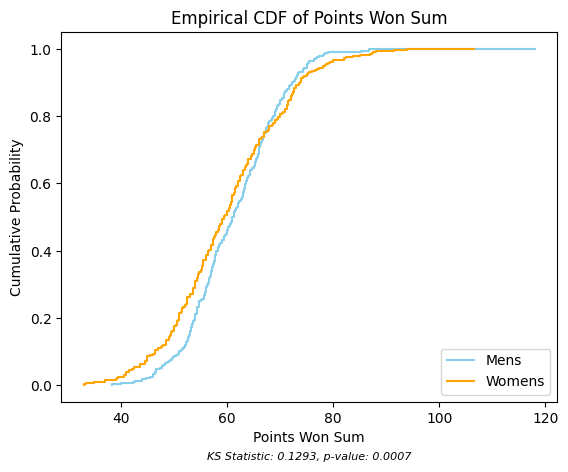

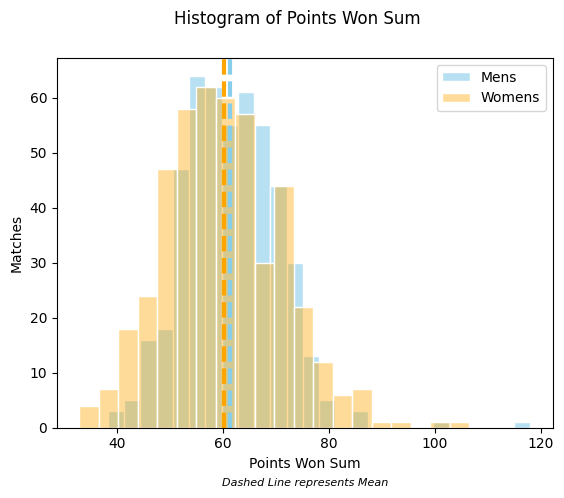

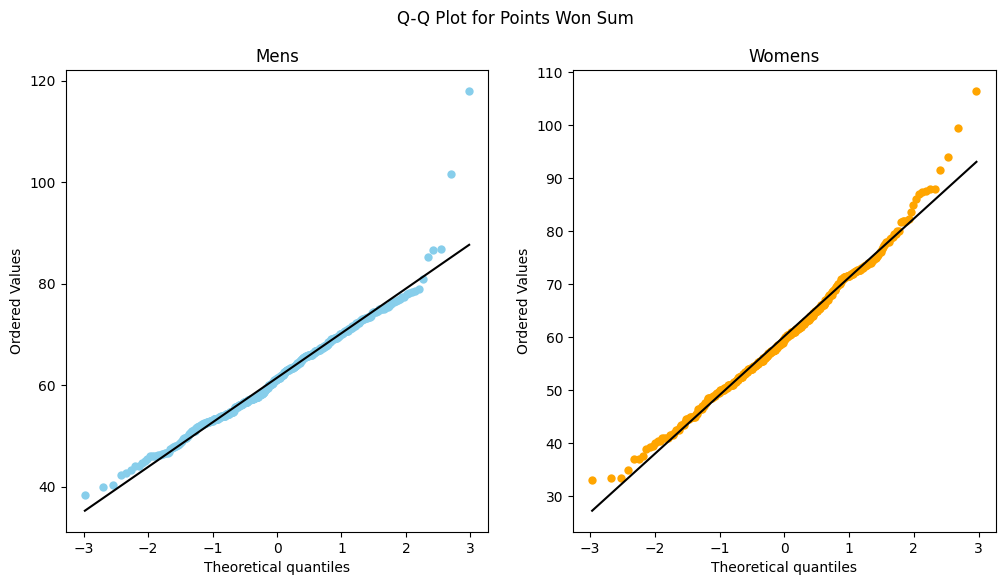

Summary Statistics for Second Serve Points Won Sum:
+-------------+------------+-----------+
| Statistic   |        Men |     Women |
+=============+============+===========+
| Mean        | 11.3247    | 10.0029   |
+-------------+------------+-----------+
| Median      | 11         | 10        |
+-------------+------------+-----------+
| Variance    |  7.12341   |  9.4683   |
+-------------+------------+-----------+
| Skewness    | -0.0284611 |  0.139025 |
+-------------+------------+-----------+
| Kurtosis    |  0.539051  |  0.143049 |
+-------------+------------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.242518 | 1.08685e-12 |
+-------------------------+---------------+-------------+
| T-test (Means)          |      7.06344  | 3.1523e-12  |
+-------------------------+---------------+-------------+
| Mann-Wh

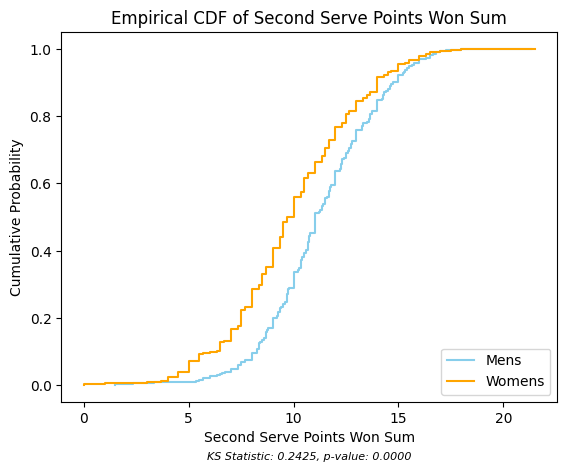

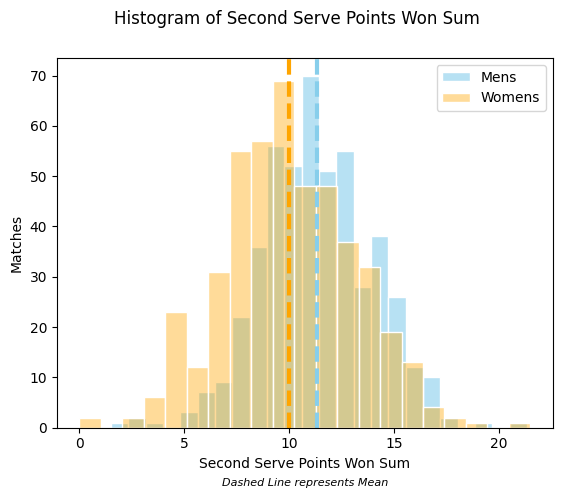

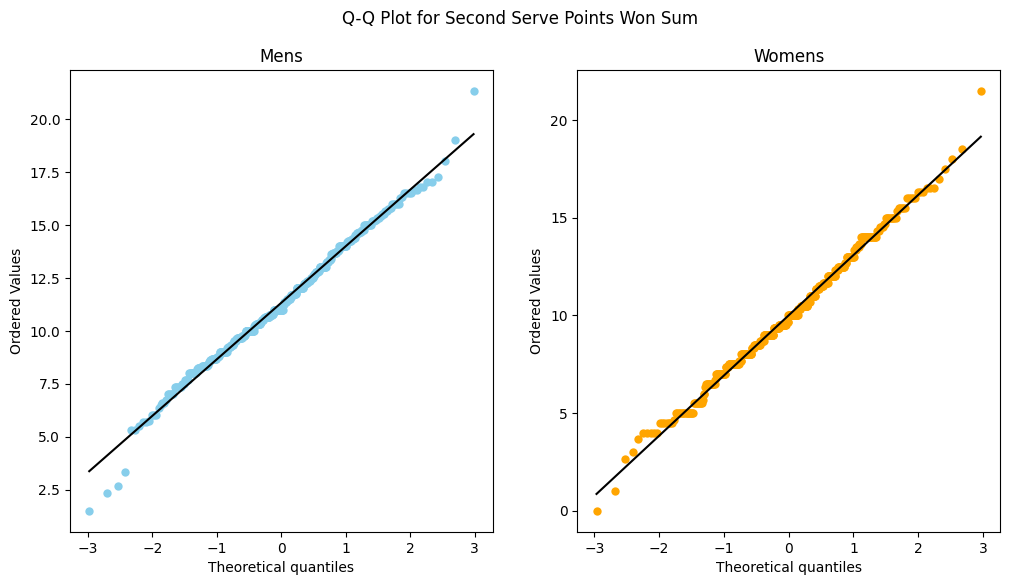

Summary Statistics for Second Serve Successful Sum:
+-------------+-----------+--------------+
| Statistic   |       Men |        Women |
+=============+===========+==============+
| Mean        | 20.189    | 19.1057      |
+-------------+-----------+--------------+
| Median      | 20        | 19           |
+-------------+-----------+--------------+
| Variance    | 18.4413   | 26.2188      |
+-------------+-----------+--------------+
| Skewness    | -0.132309 | -2.31163e-05 |
+-------------+-----------+--------------+
| Kurtosis    |  1.09028  |  0.550531    |
+-------------+-----------+--------------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |      0.13307 | 0.000408504 |
+-------------------------+--------------+-------------+
| T-test (Means)          |      3.52958 | 0.00043633  |
+-------------------------+--------------+-----

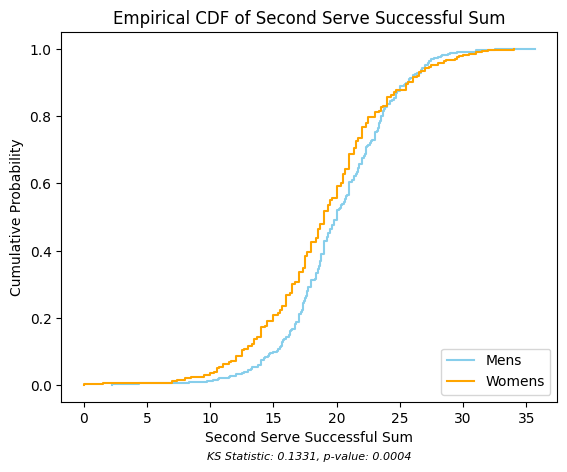

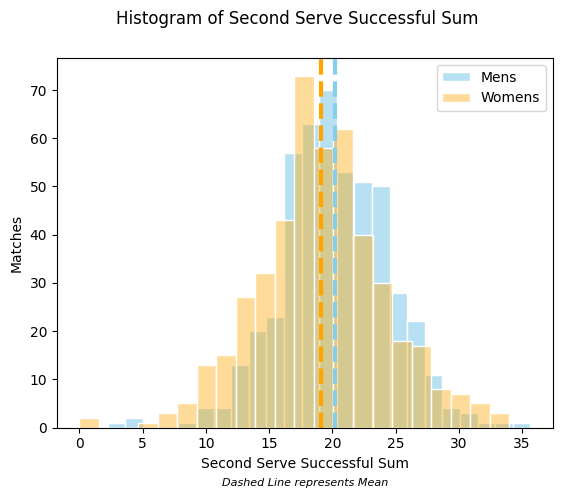

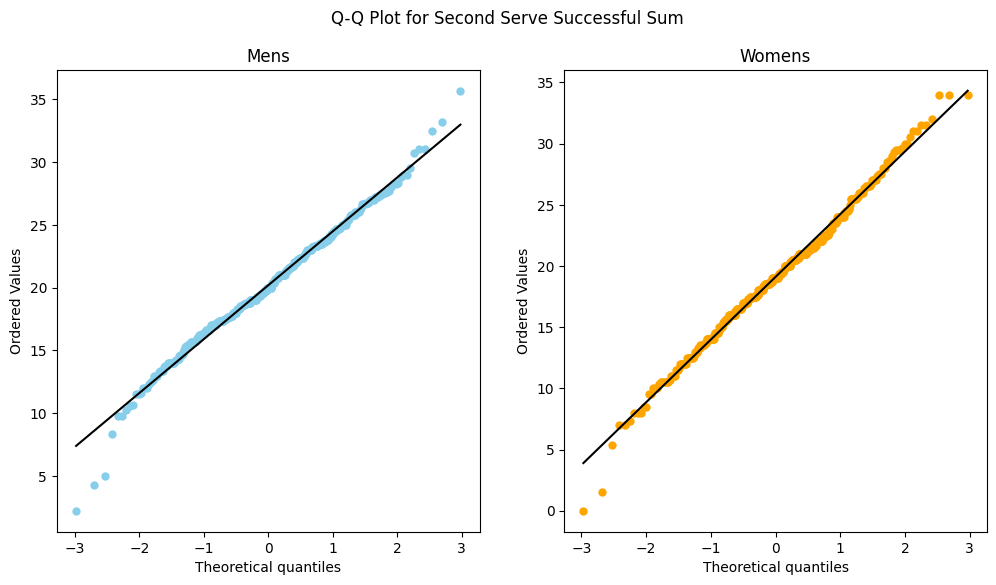

Summary Statistics for Service Games Won Sum:
+-------------+----------+-----------+
| Statistic   |      Men |     Women |
+=============+==========+===========+
| Mean        | 7.58226  |  5.85426  |
+-------------+----------+-----------+
| Median      | 7.5      |  6        |
+-------------+----------+-----------+
| Variance    | 2.14083  |  2.42135  |
+-------------+----------+-----------+
| Skewness    | 0.574625 |  0.248439 |
+-------------+----------+-----------+
| Kurtosis    | 1.57989  | -0.196004 |
+-------------+----------+-----------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.459063 | 1.91756e-45 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     17.5934   | 3.90922e-60 |
+-------------------------+---------------+-------------+
| Mann-Whitney U          | 176710       

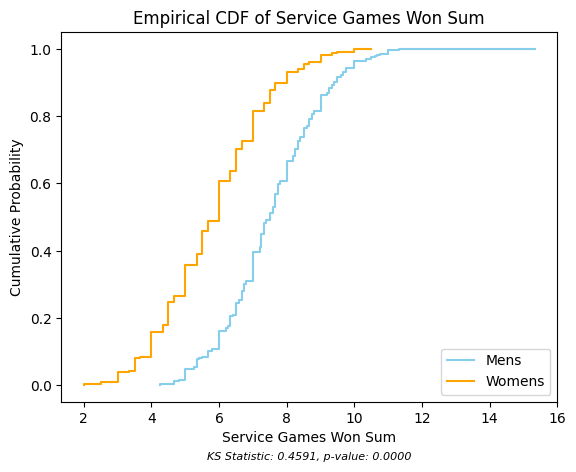

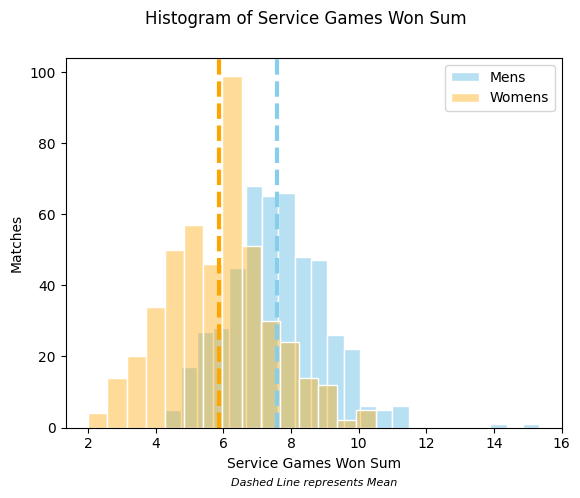

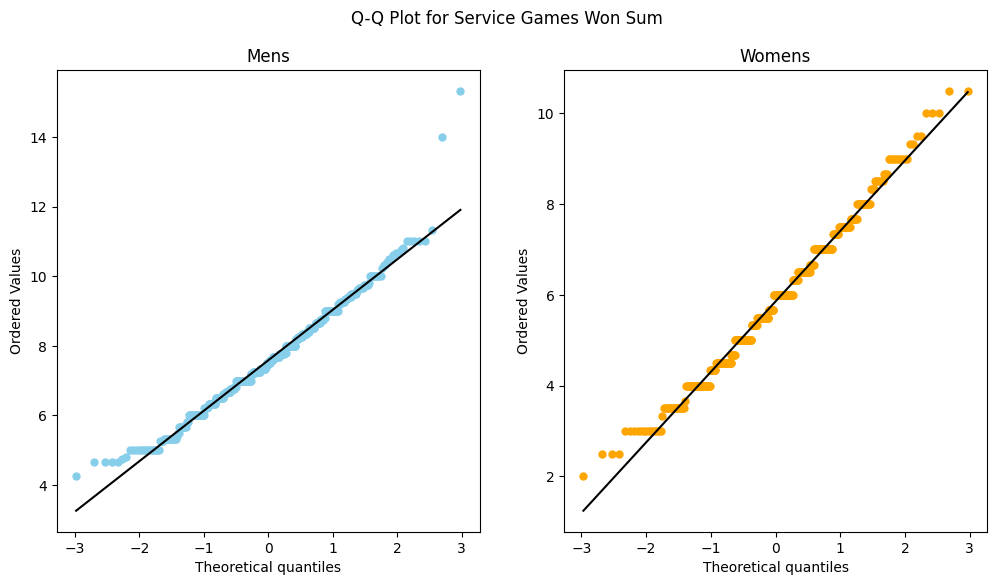

Summary Statistics for Service Points Lost Sum:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 22.4735   | 26.3373   |
+-------------+-----------+-----------+
| Median      | 22        | 26        |
+-------------+-----------+-----------+
| Variance    | 17.5505   | 33.3079   |
+-------------+-----------+-----------+
| Skewness    |  0.888426 |  0.773942 |
+-------------+-----------+-----------+
| Kurtosis    |  2.16645  |  1.38922  |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.338415 | 1.71945e-24 |
+-------------------------+--------------+-------------+
| T-test (Means)          |   -11.815    | 3.87191e-30 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 64221

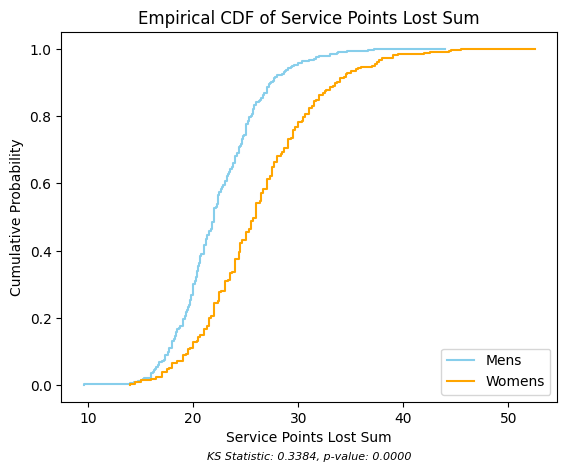

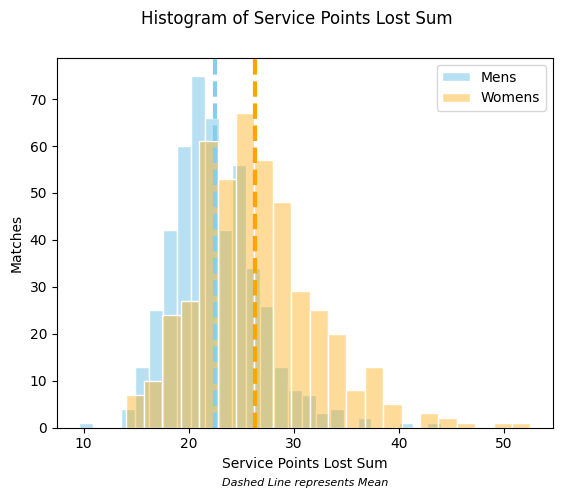

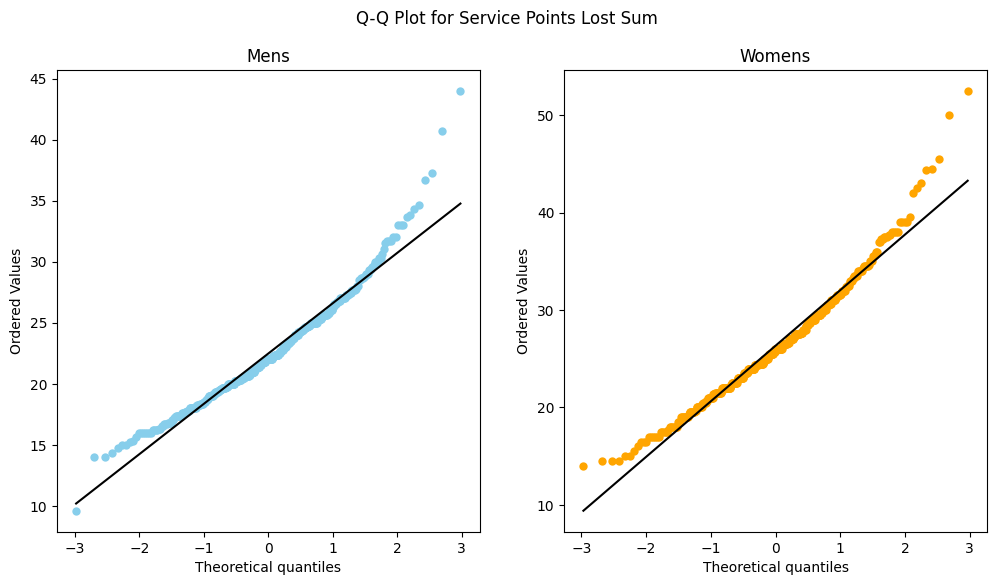

Summary Statistics for Service Points Won Sum:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        | 38.9919   | 33.9203    |
+-------------+-----------+------------+
| Median      | 38.5      | 33.5       |
+-------------+-----------+------------+
| Variance    | 44.9724   | 52.2748    |
+-------------+-----------+------------+
| Skewness    |  0.631532 |  0.29005   |
+-------------+-----------+------------+
| Kurtosis    |  2.1649   |  0.0303237 |
+-------------+-----------+------------+
+-------------------------+---------------+-------------+
| Test                    |     Statistic |     P-value |
+=========================+===============+=============+
| KS-test (Distribution)  |      0.310653 | 1.19438e-20 |
+-------------------------+---------------+-------------+
| T-test (Means)          |     11.1857   | 2.3168e-27  |
+-------------------------+---------------+-------------+
| Mann-Whitney

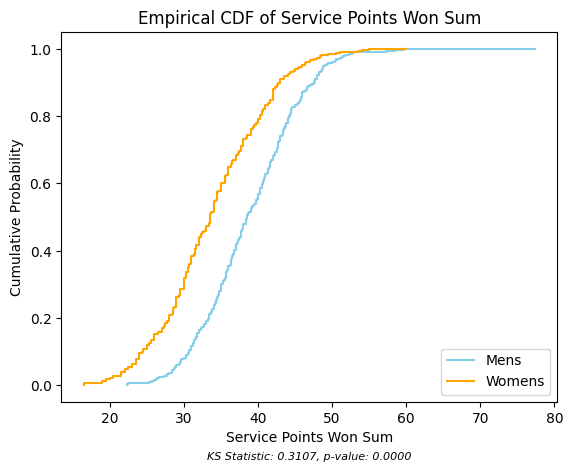

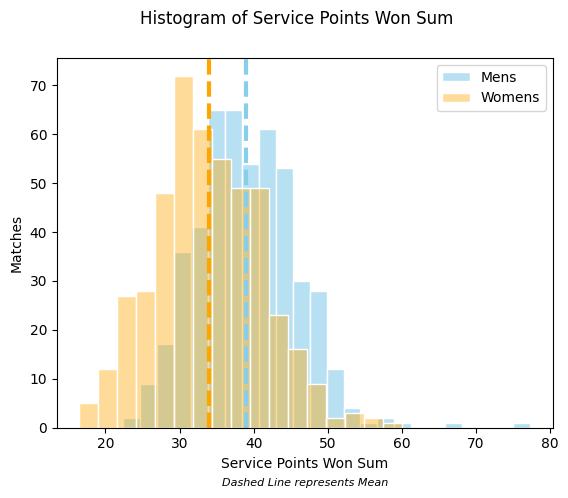

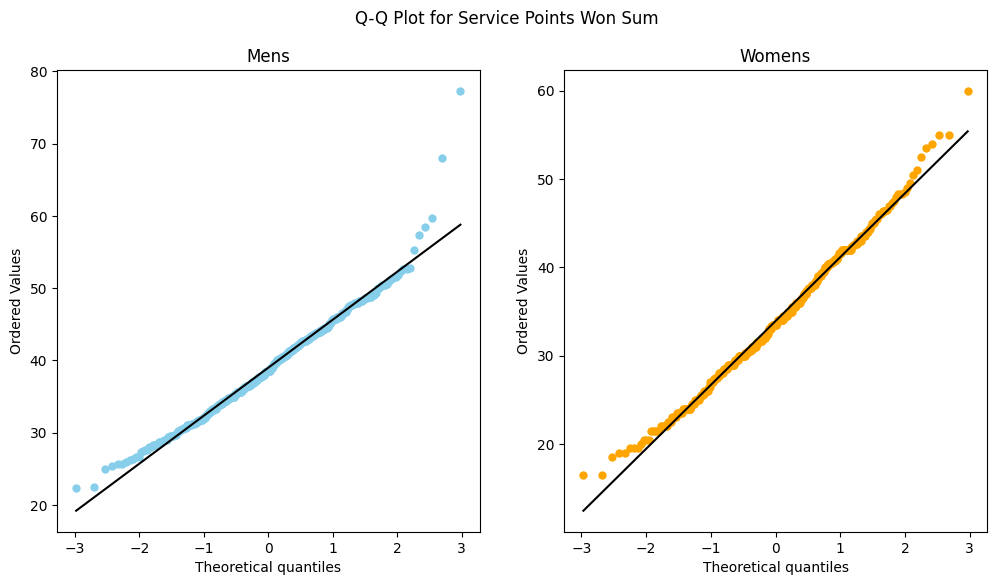

Summary Statistics for Total Breakpoints Sum:
+-------------+----------+----------+
| Statistic   |      Men |    Women |
+=============+==========+==========+
| Mean        | 5.19099  | 6.96573  |
+-------------+----------+----------+
| Median      | 5        | 7        |
+-------------+----------+----------+
| Variance    | 2.93744  | 6.17266  |
+-------------+----------+----------+
| Skewness    | 0.602112 | 0.775312 |
+-------------+----------+----------+
| Kurtosis    | 0.542826 | 1.17794  |
+-------------+----------+----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.379258 | 8.5624e-31  |
+-------------------------+--------------+-------------+
| T-test (Means)          |   -12.8289   | 7.67736e-35 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 61858        | 1.91445e-32 |
+---

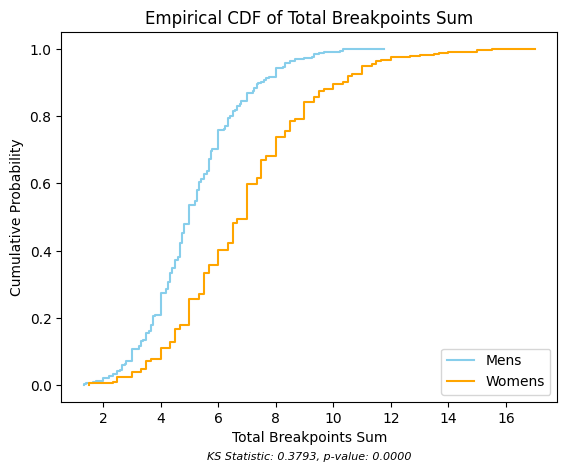

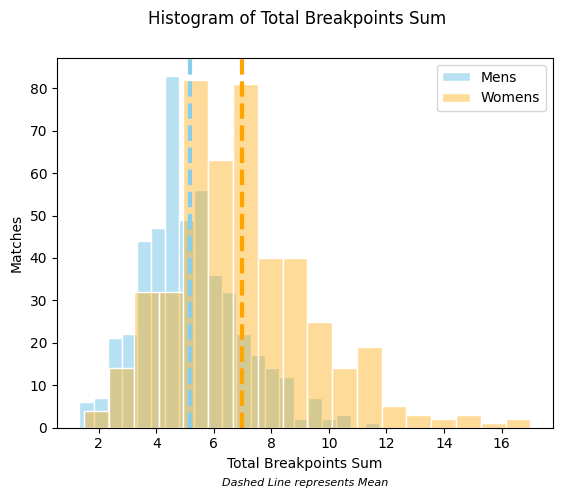

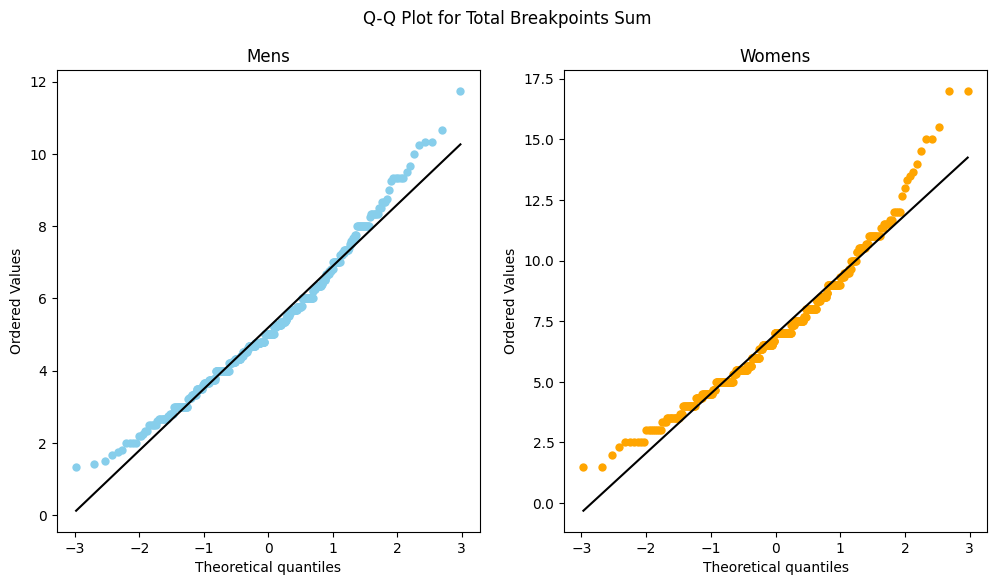

Summary Statistics for Unforced Errors Sum:
+-------------+-----------+------------+
| Statistic   |       Men |      Women |
+=============+===========+============+
| Mean        | 35.3448   |  41.017    |
+-------------+-----------+------------+
| Median      | 34.6667   |  40        |
+-------------+-----------+------------+
| Variance    | 85.4936   | 138.093    |
+-------------+-----------+------------+
| Skewness    |  0.486545 |   0.693256 |
+-------------+-----------+------------+
| Kurtosis    |  0.928184 |   1.04638  |
+-------------+-----------+------------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |     0.244871 | 6.24432e-13 |
+-------------------------+--------------+-------------+
| T-test (Means)          |    -8.26534  | 4.69642e-16 |
+-------------------------+--------------+-------------+
| Mann-Whitney U        

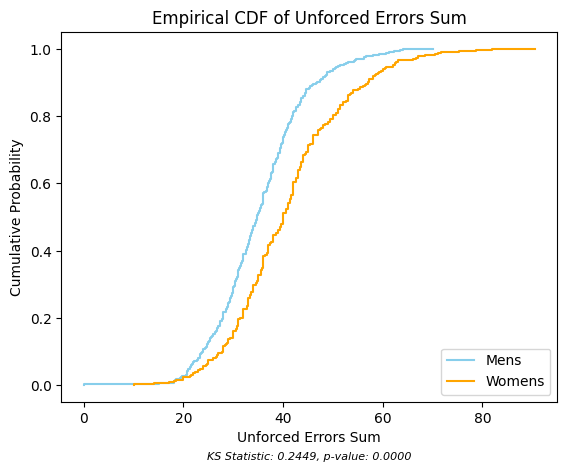

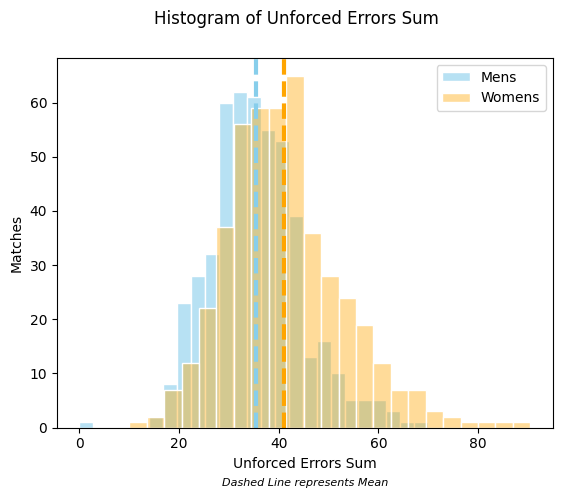

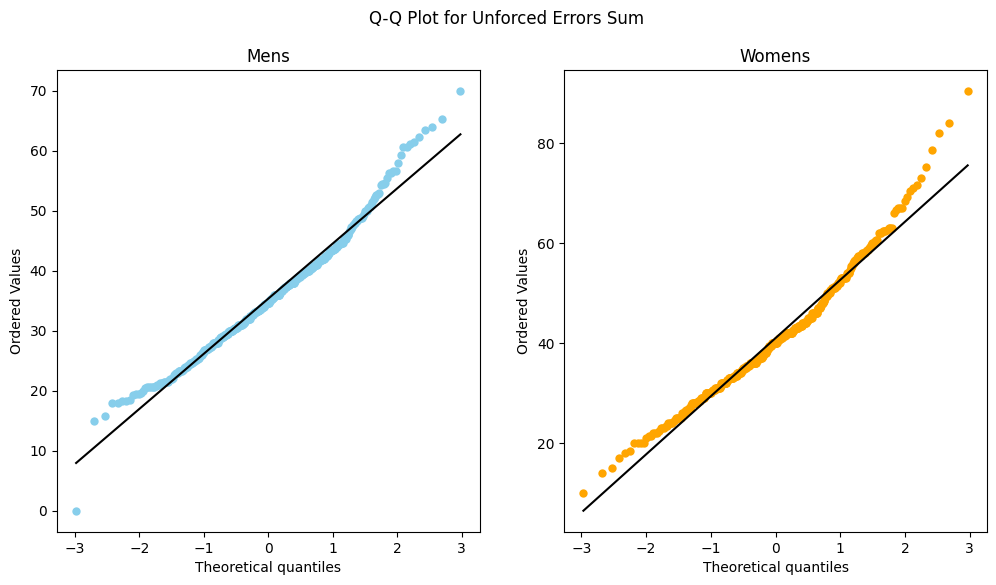

Summary Statistics for Winners Sum:
+-------------+-----------+-----------+
| Statistic   |       Men |     Women |
+=============+===========+===========+
| Mean        | 28.7628   | 30.5242   |
+-------------+-----------+-----------+
| Median      | 28.3333   | 29.3333   |
+-------------+-----------+-----------+
| Variance    | 50.2311   | 82.3719   |
+-------------+-----------+-----------+
| Skewness    |  0.480381 |  0.625688 |
+-------------+-----------+-----------+
| Kurtosis    |  1.72976  |  0.518656 |
+-------------+-----------+-----------+
+-------------------------+--------------+-------------+
| Test                    |    Statistic |     P-value |
+=========================+==============+=============+
| KS-test (Distribution)  |      0.13514 | 0.000313284 |
+-------------------------+--------------+-------------+
| T-test (Means)          |     -3.33312 | 0.000892192 |
+-------------------------+--------------+-------------+
| Mann-Whitney U          | 101034       | 0.

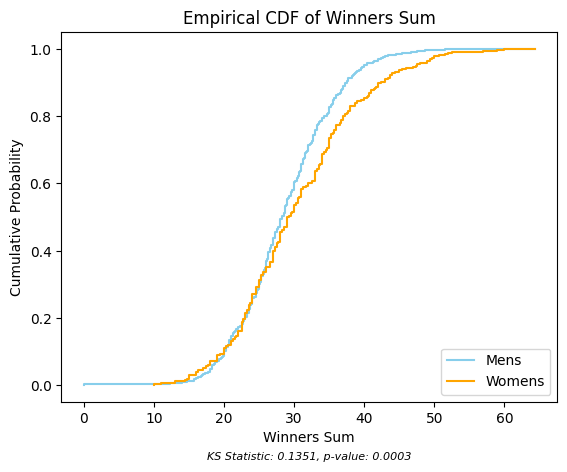

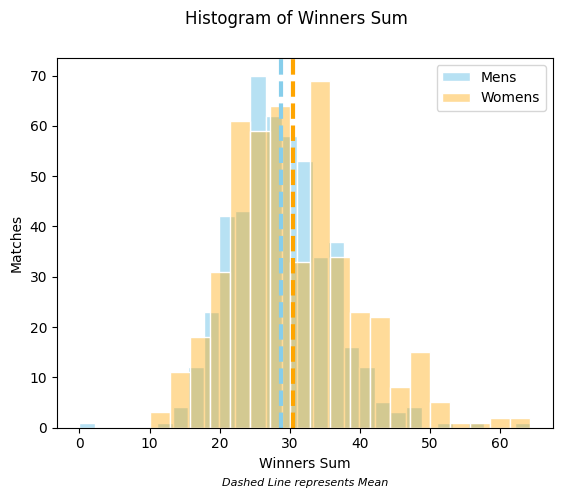

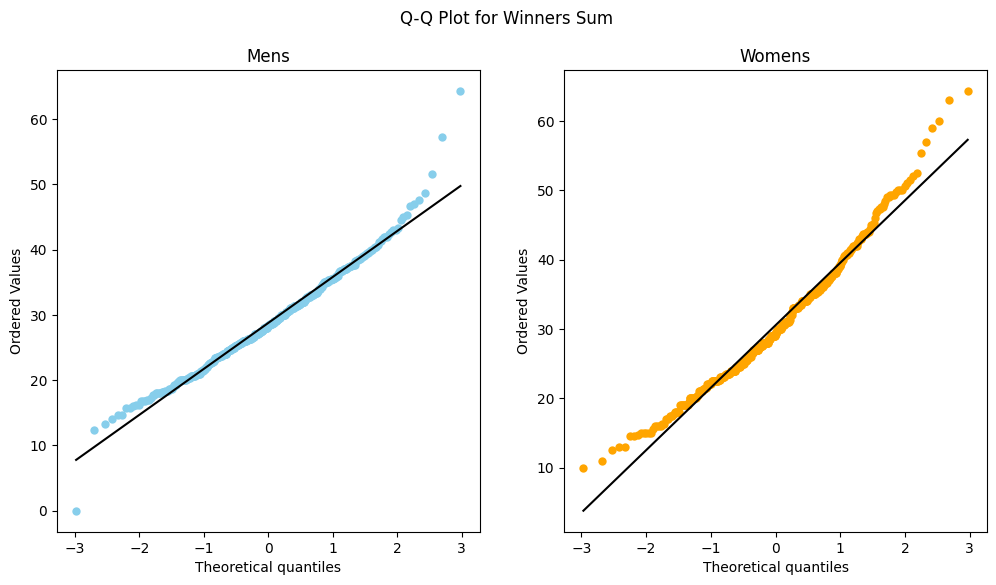

In [66]:
for feature in sorted(features_sum):
    summarize(stats_df,feature)
    plt_ecdf(stats_df, feature)
    plt_dist(stats_df, feature)
    plt_qq(stats_df, feature, "Q-Q Plot for "+feature.replace("_"," ").title())